## Covid19 Analysis & Forecast
#### by Khairul Omar
https://github.com/khairulomar/Covid-19<br>
https://www.linkedin.com/in/khairulomar/

### 1. Import and clean data

In [1]:
# Latest available Actuals
day = 10
month = 5

# Import libraries
import pandas as pd
pd.options.display.max_rows = 200
import numpy as np
import math
import json
import requests
import os
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib import cm, gridspec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import curve_fit
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore")
oneday = pd.Timedelta(1, unit='days')

In [2]:
allcols = ['date','country', 'state', 'confirmed_raw', 'confirmed', 'deaths', 'recovered', 'active', 'new_confirmed', 'new_deaths', 'new_recovered']

In [3]:
# # Multiple downloads from John Hopkins Hospital database
# start  = pd.to_datetime(f'20200122', format='%Y%m%d')
# oneday = pd.Timedelta(1, unit='days')
# end    = pd.to_datetime(f'20200315', format='%Y%m%d')
# for d in range((end - start).days+1):
#     date = start + oneday * d
#     day, month, year = str(date)[8:10], str(date)[5:7], str(date)[:4]
#     url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month}-{day}-{year}.csv'
#     df = pd.read_csv(url)
#     df.to_csv(f'data/csv/{month}-{day}-{year}.csv')

In [4]:
# One-day download from John Hopkins Hospital database
date  = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
day0, month0, year0 = str(date)[8:10], str(date)[5:7], str(date)[:4]
url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month0}-{day0}-{year0}.csv'
zero = 0 if day < 10 else ''
df = pd.read_csv(url)
df.to_csv(f'data/csv2/0{month}-{zero}{day}-2020.csv')

In [5]:
# Download Oxford global govt response tracker (new format)
# https://www.bsg.ox.ac.uk/research/research-projects/oxford-covid-19-government-response-tracker
oxford = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv')
oxford.to_csv('data/csv2/govt_tracker_raw_v2.csv')

In [6]:
# Clean up Oxford table (new format)
oxford = pd.read_csv('data/csv2/govt_tracker_raw_v2.csv')
oxcols = {'CountryName':'country', 'Date':'date', 'C1_School closing':'school',
          'C2_Workplace closing': 'workplace', 'C3_Cancel public events':'events',
          'C5_Close public transport':'transport', 'H1_Public information campaigns':'campaigns',
          'C7_Restrictions on internal movement':'movement', 'C8_International travel controls':'immigration',
          'C4_Restrictions on gatherings':'gatherings', 'C6_Stay at home requirements':'at_home',
          'H2_Testing policy':'testing', 'H3_Contact tracing':'tracing',
          'E1_Income support':'income', 'E2_Debt/contract relief':'relief', 'E3_Fiscal measures':'fiscal',
          'E4_International support':'intl_aid', 'H4_Emergency investment in healthcare':'healthcare',
          'H5_Investment in vaccines':'vaccines', 'StringencyIndex':'stringency_raw','StringencyIndexForDisplay':'stringency'}

oxford = oxford.rename(columns=oxcols)
oxford = oxford[oxcols.values()]
skipcols = ['country','fiscal','healthcare','vaccines','intl_aid','income','relief']
cols = [col for col in list(oxford.columns) if col not in skipcols]
oxford.at_home = oxford.apply(lambda row: row.movement if pd.isna(row.at_home) else row.at_home, axis=1)
oxford.at_home = oxford.apply(lambda row: row.movement if ((row.at_home==0)&(row.country=='Malaysia')) else row.at_home, axis=1)

for col in skipcols: oxford[col] = oxford[col].replace(0, np.nan)
oxford.to_csv('data/csv2/govt_tracker_v2.csv')

In [7]:
# Process files with formatting prior to 23/03/2020
path = 'data/csv/'
fileList = os.listdir(path)
df = pd.DataFrame()
for file in fileList:
    if file.endswith('.csv'):
        df0 = pd.read_csv(f'{path}{file}')
        df0.columns = map(str.lower, df0.columns)
        df0 = df0.rename(columns={'country/region':'country'})
        df0 = df0.rename(columns={'province/state':'state'})
        df0 = df0.rename(columns={'last update':'updated'})
        df0 = df0[['updated','country','state','confirmed','deaths','recovered']]
        df0.updated = pd.to_datetime(df0.updated)
        df0.state = df0.state.fillna('')
        df0['date'] = pd.to_datetime(f'{file[6:10]}{file[0:2]}{file[3:5]}', format='%Y%m%d')
        df0['fips'] = 0
        for col in ['confirmed','deaths','recovered']:
            df0[col] = df0[col].fillna(0)
            df0[col] = df0[col].astype(int)
        df = pd.concat([df, df0])
    df01 = df.copy()
        
# Process files with formatting from 23/03/2020
path = 'data/csv2/'
fileList = os.listdir(path)
df = pd.DataFrame()
for file in fileList:
    if file.endswith('2020.csv'):
        df0 = pd.read_csv(f'{path}{file}')
        df0.columns = map(str.lower, df0.columns)
        df0 = df0.rename(columns={'country_region':'country'})
        df0 = df0.rename(columns={'province_state':'state'})
        df0 = df0.rename(columns={'last_update':'updated'})
        df0 = df0[['updated','country','state','confirmed','deaths','recovered','active','fips','admin2']]
        df0.updated = pd.to_datetime(df0.updated)
        df0.state = df0.state.fillna('')
        df0['date'] = pd.to_datetime(f'{file[6:10]}{file[0:2]}{file[3:5]}', format='%Y%m%d')
        for col in ['confirmed','deaths','recovered', 'active','fips']:
            df0[col] = df0[col].fillna(0)
            df0[col] = df0[col].astype(int)
        df = pd.concat([df, df0])
    df02 = df.copy()
    
# Append data from Hubei prior to 22/01/2020
raw = pd.read_csv('data/csv/older/pre_01-22-2020.csv')
prior = pd.DataFrame(columns=df0.columns)
for col in ['confirmed', 'country', 'deaths', 'recovered', 'state', 'updated']:
    prior[col] = raw[col]
for col in ['confirmed', 'deaths', 'recovered']:
    prior[col] = prior[col].astype(int)
prior.state = 'Hubei'
prior.country = 'Mainland China'
prior.fips = 0
prior.updated = pd.to_datetime(prior.updated, format='%d/%m/%Y')
prior.date = prior.updated

df = pd.concat([df02, df01, prior]).reset_index()
df.active = df.active.fillna(0)
df0 = df.copy()
df0.to_csv('data/dfdata/df0.csv') # raw before manual adjustments

In [8]:
# Overwrite raw data with manual fix e.g. when cumulative data had to be restated to be lower
manual_fix = pd.read_csv('data/dfdata/manual_fix.csv')
manual_fix.date= pd.to_datetime(manual_fix.date, format='%Y%m%d')
for n in range(len(manual_fix)):
    row = manual_fix.iloc[n]
    ix = df0[(df0.country==row.country) & (df0.date==row.date) & ((pd.isna(df0.state))|(df0.state==''))].index
    c = df0.columns.get_loc('confirmed')
    d = df0.columns.get_loc('deaths')
    if row.confirmed > 0: df0.iloc[ix,c] = row.confirmed
    if row.deaths > 0: df0.iloc[ix,d] = row.deaths
for col in ['confirmed','deaths']:
    df0[col] = df0[col].astype('int')

In [9]:
df = df0.copy()

# Geo clean-up mapping dictionary
geo = json.load(open('data/geo.json'))
df.country = df.country.apply(lambda row: geo['countries'][row] if row in list(geo['countries'].keys()) else row)
df['temp'] = ''
for i in range(len(df)):
    state = df.iloc[i].state
    country = df.iloc[i].country
    
    if (state == 'None') | (state == 'UK'):
        df.iloc[i, df.columns.get_loc('state')] = country
    elif state[:8]=='Falkland':
        df.iloc[i, df.columns.get_loc('state')] = 'Falkland Islands'
    elif state.find('Princess') > 0:
        if country != 'Cruise Ship':
            df.iloc[i, df.columns.get_loc('state')] = f'Cruise {country}'
        else:
            df.iloc[i, df.columns.get_loc('state')] = 'Cruise Ship'
    elif country == 'United States':
        if state == 'Washington, D.C.':
            s = 'District of Columbia'
        elif state == 'US':
            s = 'Unassigned'
        elif state == 'Chicago':
            s = 'Illinois'
        elif state.find('Virgin Islands')!=-1:
            s = 'US Virgin Islands'
        elif state.find(', ') > 0:
            s0 = state[state.find(', ')+2:state.find(', ')+4]
            s = geo['us_states'][s0]
        elif state in list(geo['us_states'].keys()):
            s = geo['us_states'][state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s
            
    elif country == 'Canada':
        if state.find('Princess') > 0:
            s = 'Cruise Ship'               
        elif state.find(', ') > 0:
            ca = {'Edmonton, Alberta':'Alberta', 'Calgary, Alberta':'Alberta',
                  'London, ON':'Ontario', 'Toronto, ON':'Ontario', ' Montreal, QC':'Quebec'}
            s = ca[state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s
df['state'] = df.apply(lambda row: row['temp'] if row['temp']!='' else (row['state'] if row['state']!='' else row['country']), axis=1)
territories = ['Hong Kong', 'Macau',
               'Aruba', 'Curacao', 'Sint Maarten',
               'French Polynesia', 'New Caledonia', 'Saint Barthelemy', 'Saint Pierre and Miquelon', 'St Martin',
               'Northern Mariana Islands', 'Guam', 'Puerto Rico', 'American Samoa', 'US Virgin Islands']
df.country = df.apply(lambda row: row.state if (row.state in territories) else row.country, axis=1)
df.country = df.apply(lambda row: row.state if (row.country in ['United Kingdom', 'Denmark']) else row.country, axis=1)
df.drop('temp', axis=1, inplace=True)

df = pd.pivot_table(df, values=['confirmed','deaths','recovered','active'], index=['date','country','state'], columns=None, aggfunc='sum')
df = df.rename(columns={'confirmed':'confirmed_raw'})
df = df.reset_index()
dftemp = pd.DataFrame()
for state in df.state.unique():
    dfstate = df[df.state==state].copy()
    dfstate = dfstate.sort_index(ascending=False)
    dfstate['confirmed'] = dfstate.confirmed_raw
    # Replace raw with average between 2 dates due to incomplete data due to cut-off reporting time
    #e.g. if new cases suddenly drop by 90% in one day, most likely it's due to incomplete data
    for i in range(1,len(dfstate.index)-1):
        ratio = 1/2 # smoothing average ratio
        if abs((dfstate.iloc[i+1].confirmed_raw - dfstate.iloc[i].confirmed_raw) / (dfstate.iloc[i].confirmed_raw - dfstate.iloc[i-1].confirmed_raw)) < 0.1:
            dfstate.iloc[i, dfstate.columns.get_loc('confirmed')] = int(dfstate.iloc[i+1].confirmed_raw * ratio
                                                                        + dfstate.iloc[i-1].confirmed_raw * (1-ratio))

    for col in ['confirmed','deaths','recovered']:
        colname = f'new_{col}'
        dfstate[colname] = dfstate[col].diff(-1)
        dfstate[colname] = dfstate[colname].fillna(dfstate[col])
        dfstate[colname] = dfstate[colname].astype('int')
    dftemp =  pd.concat([dftemp, dfstate])
df = dftemp.sort_values(['date','new_confirmed'], ascending=False)

newcols = ['date','country', 'state', 'confirmed_raw', 'confirmed', 'deaths', 'recovered', 'active', 'new_confirmed', 'new_deaths', 'new_recovered']

df = df[allcols]
df = df.reset_index(drop=True)

df.to_csv('data/dfdata/df.csv')

In [10]:
# Read from cleansed data
df = pd.read_csv('data/dfdata/df.csv')
df = df.drop(df.columns[0], axis=1)
df.date= pd.to_datetime(df.date)

In [11]:
# Function to reshape df into country-level or state-level etc
def subset_geo(source, indices):
    data = pd.pivot_table(source, values=source.columns[3:], index=indices, columns=None, aggfunc='sum')
    data = data.reset_index()
    data = data.sort_values('date')
    data = data[indices + allcols[-7:]]
    return data

In [12]:
# Function to calculate day-to-day growth rate
def calc_growth(data, geo='country', rolling_window=3):
    dftemp = pd.DataFrame()
    for g in data[geo].unique():
        dfc = data[data[geo]==g].copy().reset_index(drop=True)
        dfc['new_growth'] = 0
        dfc['growth'] = 0
        for i in range(1,len(dfc.index)):
            for newcol in ['growth', 'new_growth']:
                oldcol = 'confirmed' if newcol == 'growth' else 'new_confirmed'
                dfc.iloc[i, dfc.columns.get_loc(newcol)] = 0 if dfc.iloc[i-1][oldcol] == 0 else round(dfc.iloc[i][oldcol]/dfc.iloc[i-1][oldcol],3)
        dftemp =  pd.concat([dftemp, dfc])
    data = dftemp.copy()
    data['growth_avg'] = round(data.growth.rolling(window=rolling_window).mean(),3).clip(1)
    data['growth_avg_7'] = round(data.growth.rolling(window=7).mean(),3).clip(1)
    data = data.sort_values(['date', 'confirmed'], ascending=False)
    data = data.set_index('date')
    return data

In [13]:
# Country-level data (df1)
df1 = subset_geo(source=df, indices=['date','country'])
df1 = calc_growth(df1, geo='country', rolling_window=3)
df1 = pd.pivot_table(df, values=df.columns[3:], index=['date','country'], columns=None, aggfunc='sum')
df1 = df1.reset_index()
df1 = df1.sort_values('date')
df1 = df1[['date','country'] + allcols[3:]]
df1 = calc_growth(df1, geo='country', rolling_window=3)
df1.to_csv('data/dfdata/df1.csv')

In [14]:
# fig, axes = plt.subplots(figsize=(14,10), nrows=2, ncols=2)
# countries = ['France','Spain','United States','United Kingdom']
# for i, ax in zip(range(len(countries)), axes.flat):
#     data = df1[df1.country==countries[i]].sort_index()[40:]
#     ax.plot(data.confirmed, label='smoothed', ls='dashed', c='C0')
#     ax.plot(data.confirmed_raw, label='raw', c='C0')
#     ax2 = ax.twinx()
#     ax2.plot(data.new_confirmed, label='daily', ls='dashed', c='C3')
#     ax2.plot(data.confirmed_raw.diff(), label='daily', c='C3')
#     ax2.plot(data.confirmed.diff(), label='daily', ls=':', c='C3')
#     ax.legend()
#     ax.set_title(countries[i])
#     ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
# plt.show()

In [15]:
df1 = pd.read_csv('data/dfdata/df1.csv', index_col=0)
df1.index = pd.to_datetime(df1.index)

In [16]:
# Combine df1 with Oxford table (df1a)
oxford = pd.read_csv('data/csv2/govt_tracker_v2.csv', index_col=0)
oxford.date = pd.to_datetime(oxford.date, format='%Y%m%d')
oxford = oxford.set_index('date',drop=True)

df1a = pd.merge(df1.reset_index(), oxford.reset_index(),  how='left', left_on=['date','country'], right_on = ['date','country'])
df1a = df1a.set_index('date')
df1a.to_csv('data/dfdata/df1a.csv')

In [17]:
# # Country-level data with and without Hubei province and New York state (df1b)

# china_excl_hubei = df[(df.country=='China') & (df.state!='Hubei')]
# china_excl_hubei = subset_geo(source=china_excl_hubei, indices=['date','country'])
# china_excl_hubei = calc_growth(china_excl_hubei, geo='country', rolling_window=3)
# china_excl_hubei.country = 'China (excl Hubei)'

# hubei = df[df.state=='Hubei']
# hubei = subset_geo(source=hubei, indices=['date','country'])
# hubei = calc_growth(hubei, geo='country', rolling_window=3)
# hubei.country = 'China (Hubei)'

# usa_excl_ny = df[(df.country=='United States') & (df.state!='New York')]
# usa_excl_ny = subset_geo(source=usa_excl_ny, indices=['date','country'])
# usa_excl_ny = calc_growth(usa_excl_ny, geo='country', rolling_window=3)
# usa_excl_ny.country = 'United States (excl NY)'

# nystate = df[df.state=='New York']
# nystate = subset_geo(source=nystate, indices=['date','country'])
# nystate = calc_growth(nystate, geo='country', rolling_window=3)
# nystate.country = 'United States (NY)'

# # Combine
# df1b = pd.concat([df1, china_excl_hubei, hubei, usa_excl_ny, nystate]).reset_index()
# df1b = df1b.sort_values(['date','confirmed'], ascending=False)
# df1b = df1b.set_index('date', drop=True)

# # State/province-level data (df4)
# df4 = subset_geo(source=df, indices=['date','country','state'])
# df4 = calc_growth(df4, geo='state', rolling_window=3)
# df4.to_csv('data/dfdata/df4.csv')

In [18]:
ccodes = pd.read_csv('data/dfdata/countrycode.csv', encoding='latin-1', index_col=0)
pop = pd.read_csv('data/dfdata/population.csv', index_col=0)

In [19]:
# Testing database
testraw = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/testing/covid-testing-all-observations.csv')
testraw.to_csv('data/csv2/testing_data_raw.csv')

testraw = pd.read_csv('data/csv2/testing_data_raw.csv', index_col=0)
testcols = {'Entity':'country', 'Date':'date', 'Source URL':'source', 'Notes': 'notes', 'Cumulative total':'tested'}
testraw = testraw.rename(columns=testcols).iloc[:,:7]
testraw['type'] = testraw.country.apply(lambda row: row[row.find(' -')+3:].replace(' ','_'))
testraw.country = testraw.country.apply(lambda row: row[:row.find(' -')])
testraw.date = pd.to_datetime(testraw.date)

datelist = []
date0 = pd.to_datetime('20200118', format='%Y%m%d')
while date0 <= df1.index.max():
    datelist.append(date0)
    date0 = date0 + oneday
countries = testraw.country.unique()
# If there are more than 1 type of test, pick the highest one (aggfunc='max')
testraw1 = pd.pivot_table(testraw, values='tested', index=['date','country'], columns=None, aggfunc='max')
testraw1 = testraw1.reset_index()

testnum = pd.DataFrame()
for country in countries:
    temp = pd.DataFrame(index=datelist)
    temp = temp.join(testraw1[testraw1.country==country].set_index('date'))
    temp.country = country
    temp['tested_raw'] = temp.tested
    
    # Extrapolate testing to date as a smooth fill between 2 available dates of data
    temp['tested_raw_ffill'] = temp.tested.fillna(method='ffill')
    temp.tested = temp.tested.interpolate()
    
    # but don't fill beyond latest available data
    lastdata = temp[temp.tested_raw>0].index[-1]
    temp.tested = temp.apply(lambda row: row.tested if row.name <= lastdata else np.nan, axis=1)
    
    # Daily tests
    temp['tested_daily'] = temp.tested.diff().replace(0, np.nan)
    temp['tested_daily_ffill'] = temp.tested_daily.fillna(method='ffill')
    
    for i in range(1, len(temp)):
        before = temp.iloc[i-1, temp.columns.get_loc('tested')]
        latest = temp.iloc[i,   temp.columns.get_loc('tested')]
        temp.iloc[i, temp.columns.get_loc('tested')] = before if latest<before else latest
    
    latest_data_date = temp[temp.tested_raw>0].index[-1]
    testnum = pd.concat([testnum, temp])
    
tests = testnum.join(pop, on='country')
tests['testper1Mdaily'] = tests.apply(lambda row: np.nan if pd.isna(row.tested_daily) else round(row.tested_daily/row['pop']*1000000,1), axis=1)
tests['testper1Mdaily_ff'] = tests.testper1Mdaily.fillna(method='ffill')
tests.to_csv('data/csv2/testing_data.csv')

In [20]:
sg = tests[tests.country=='Singapore'].copy()
sg.tail(20)

country         tested  tested_raw  tested_raw_ffill  \
2020-04-21  Singapore  124937.571429         NaN          121774.0   
2020-04-22  Singapore  128101.142857         NaN          121774.0   
2020-04-23  Singapore  131264.714286         NaN          121774.0   
2020-04-24  Singapore  134428.285714         NaN          121774.0   
2020-04-25  Singapore  137591.857143         NaN          121774.0   
2020-04-26  Singapore  140755.428571         NaN          121774.0   
2020-04-27  Singapore  143919.000000    143919.0          143919.0   
2020-04-28  Singapore  148445.428571         NaN          143919.0   
2020-04-29  Singapore  152971.857143         NaN          143919.0   
2020-04-30  Singapore  157498.285714         NaN          143919.0   
2020-05-01  Singapore  162024.714286         NaN          143919.0   
2020-05-02  Singapore  166551.142857         NaN          143919.0   
2020-05-03  Singapore  171077.571429         NaN          143919.0   
2020-05-04  Singapore  175604.000000    175604.0          175604.0   
2020-05-05  Singapore            NaN         NaN          175604.0   
2020-05-06  Singapore            NaN         NaN          175604.0   
2020-05-07  Singapore            NaN         NaN          175604.0   
2020-05-08  Singapore            NaN         NaN          175604.0   
2020-05-09  Singapore            NaN         NaN          175604.0   
2020-05-10  Singapore            NaN         NaN          175604.0   

            tested_daily  tested_daily_ffill        pop   area  \
2020-04-21   3163.571429         3163.571429  5703600.0  716.0   
2020-04-22   3163.571429         3163.571429  5703600.0  716.0   
2020-04-23   3163.571429         3163.571429  5703600.0  716.0   
2020-04-24   3163.571429         3163.571429  5703600.0  716.0   
2020-04-25   3163.571429         3163.571429  5703600.0  716.0   
2020-04-26   3163.571429         3163.571429  5703600.0  716.0   
2020-04-27   3163.571429         3163.571429  5703600.0  716.0   
2020-04-28   4526.428571         4526.428571  5703600.0  716.0   
2020-04-29   4526.428571         4526.428571  5703600.0  716.0   
2020-04-30   4526.428571         4526.428571  5703600.0  716.0   
2020-05-01   4526.428571         4526.428571  5703600.0  716.0   
2020-05-02   4526.428571         4526.428571  5703600.0  716.0   
2020-05-03   4526.428571         4526.428571  5703600.0  716.0   
2020-05-04   4526.428571         4526.428571  5703600.0  716.0   
2020-05-05           NaN         4526.428571  5703600.0  716.0   
2020-05-06           NaN         4526.428571  5703600.0  716.0   
2020-05-07           NaN         4526.428571  5703600.0  716.0   
2020-05-08           NaN         4526.428571  5703600.0  716.0   
2020-05-09           NaN         4526.428571  5703600.0  716.0   
2020-05-10           NaN         4526.428571  5703600.0  716.0   

            testper1Mdaily  testper1Mdaily_ff  
2020-04-21           554.7              554.7  
2020-04-22           554.7              554.7  
2020-04-23           554.7              554.7  
2020-04-24           554.7              554.7  
2020-04-25           554.7              554.7  
2020-04-26           554.7              554.7  
2020-04-27           554.7              554.7  
2020-04-28           793.6              793.6  
2020-04-29           793.6              793.6  
2020-04-30           793.6              793.6  
2020-05-01           793.6              793.6  
2020-05-02           793.6              793.6  
2020-05-03           793.6              793.6  
2020-05-04           793.6              793.6  
2020-05-05             NaN              793.6  
2020-05-06             NaN              793.6  
2020-05-07             NaN              793.6  
2020-05-08             NaN              793.6  
2020-05-09             NaN              793.6  
2020-05-10             NaN              793.6

### 2. Analyse latest data

In [21]:
# Display one day data
day = day
month = month
date = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')

top0 = 50
latest = df1.loc[date].iloc[:,:8]
print(f'\nTop {top0} countries by total cases as of {date.day}/{date.month}/2020')
display(latest[:top0])


Top 50 countries by total cases as of 10/5/2020


country  confirmed_raw  confirmed  deaths  recovered  \
date                                                                            
2020-05-10         United States        1326826    1326826   79404     216169   
2020-05-10                 Spain         224350     224350   26621     136166   
2020-05-10        United Kingdom         219183     219183   31855          0   
2020-05-10                 Italy         219070     219070   30560     105186   
2020-05-10                Russia         209688     209688    1915      34306   
2020-05-10                France         176970     176970   26380      56217   
2020-05-10               Germany         171879     171879    7569     144400   
2020-05-10                Brazil         162699     162699   11123      64957   
2020-05-10                Turkey         138657     138657    3786      92691   
2020-05-10                  Iran         107603     107603    6640      86143   
2020-05-10                 China          82918      82918    4633      78144   
2020-05-10                Canada          70091      70091    4991      32109   
2020-05-10                  Peru          67307      67307    1889      21349   
2020-05-10                 India          67161      67161    2212      20969   
2020-05-10               Belgium          53081      53081    8656      13642   
2020-05-10           Netherlands          42633      42633    5440          0   
2020-05-10          Saudi Arabia          39048      39048     246      11457   
2020-05-10                Mexico          35022      35022    3465      21824   
2020-05-10              Pakistan          30334      30334     659       8063   
2020-05-10           Switzerland          30305      30305    1833      26600   
2020-05-10               Ecuador          29559      29559    2127       3433   
2020-05-10                 Chile          28866      28866     312      13112   
2020-05-10              Portugal          27581      27581    1135       2549   
2020-05-10                Sweden          26322      26322    3225       4971   
2020-05-10             Singapore          23336      23336      20       2721   
2020-05-10               Ireland          22996      22996    1458      17110   
2020-05-10               Belarus          22973      22973     131       6406   
2020-05-10                 Qatar          22520      22520      14       2753   
2020-05-10  United Arab Emirates          18198      18198     198       4804   
2020-05-10                Israel          16477      16477     252      11430   
2020-05-10                Poland          15996      15996     800       5698   
2020-05-10               Austria          15871      15871     618      13991   
2020-05-10                 Japan          15777      15777     624       8127   
2020-05-10               Romania          15362      15362     961       7051   
2020-05-10               Ukraine          15232      15232     391       3060   
2020-05-10            Bangladesh          14657      14657     228       2650   
2020-05-10             Indonesia          14032      14032     973       2698   
2020-05-10              Colombia          11063      11063     463       2705   
2020-05-10           South Korea          10909      10909     256       9632   
2020-05-10           Philippines          10794      10794     719       1924   
2020-05-10               Denmark          10429      10429     529       8217   
2020-05-10    Dominican Republic          10347      10347     388       2763   
2020-05-10                Serbia          10032      10032     215       2732   
2020-05-10          South Africa          10015      10015     194       4173   
2020-05-10                 Egypt           9400       9400     525       2075   
2020-05-10                Kuwait           8688       8688      58       2729   
2020-05-10                Panama           8448       8448     244       4687   
2020-05-10        Czech Republic           8123       81

In [22]:
top = 20
# Select diplay data
until = date
data = df1[until:]

# Plot data
print(f'\nNew confirmed cases from 1/2/2020 to {date.day}/{date.month}/2020')
countries = list(latest[:top-2].country) + ['Australia', 'Malaysia']
# countries.remove('Cruise Ship')
# fig, axes = plt.subplots(ncols=4, nrows=round(len(countries)/4), figsize=(11,6), constrained_layout=True)
# for i, ax in zip(range(len(countries)), axes.flat):
#     cdata = data[data.country==countries[i]]
#     ax.plot(cdata.new_confirmed)
#     ax.text(until + oneday*2, cdata.loc[until].new_confirmed, format(cdata.loc[until].new_confirmed, ","), color='red')
#     ax2 = ax.twinx()
#     ax2.bar(cdata.index, cdata.confirmed, color='red', alpha=0.05, width=1)
#     ax.set_title(f'{countries[i]} {format(cdata.loc[until].confirmed, ",")}', fontsize=10)
#     ax.axis('off')
#     ax2.axis('off')
# plt.tight_layout()
# plt.show()


New confirmed cases from 1/2/2020 to 10/5/2020


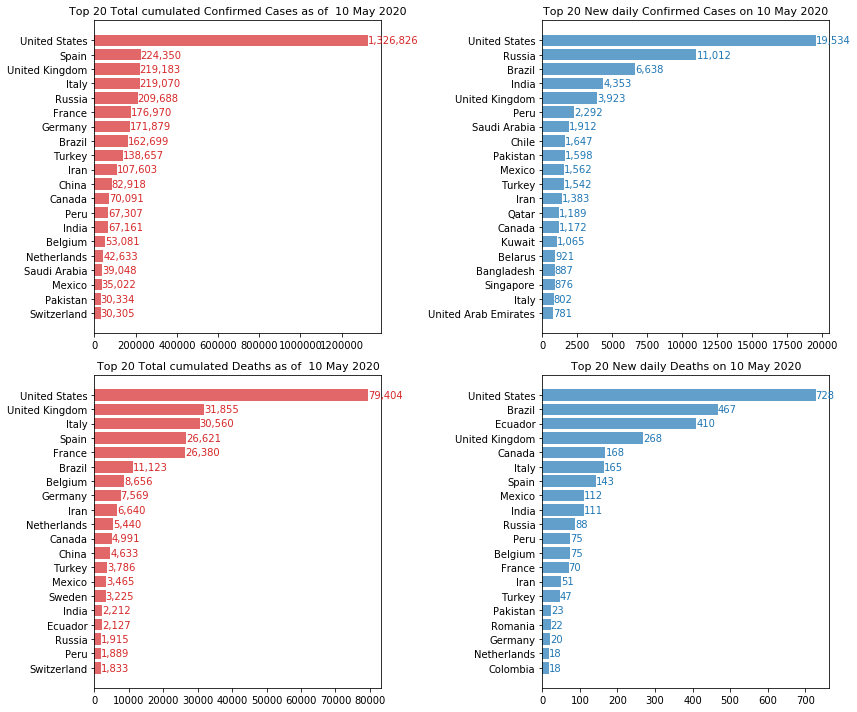

In [23]:
mdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
cols = ['confirmed','new_confirmed','deaths','new_deaths']
titles = ['Total cumulated Confirmed Cases as of  ','New daily Confirmed Cases on ','Total cumulated Deaths as of  ','New daily Deaths on ']
colors = ['C3','C0','C3','C0']
fig, axes = plt.subplots(figsize=(12,10), nrows=2, ncols=2)
topnum = 20
for i, ax in zip(range(len(cols)), axes.flat):
    data = latest[['country',cols[i]]].reset_index(drop=True).set_index('country').sort_values(by=cols[i])[-topnum:]
    ax.barh(data.index, data[cols[i]], color=colors[i], alpha=0.7)
    ax.set_title(f'Top {topnum} {titles[i]}{date.day} {mdict[date.month]} 2020', fontsize='11')
    for n, v in enumerate(data[cols[i]]):
        ax.text(v, n, format(v, ","), va='center', fontsize=10, color=colors[i])
plt.tight_layout()
plt.savefig('img/total_cases_bar', pad_inches=0)
plt.show()

In [24]:
threshold = 50 # set min threshold

cols = ['country','confirmed','new_confirmed','growth','growth_avg','growth_avg_7']
df2 = df1a[cols].reset_index()
df2 = df2.sort_values('date')

print(f'\nTop 20 countries with the highest day-on-day growth as of {date.day}/{date.month}/2020')
growthdata = df2.loc[(df2.date==date) & (df2.confirmed > 100)].sort_values(by='growth', ascending=False).set_index('country', drop=True)
growthdata[['confirmed','growth','growth_avg']][:20]


Top 20 countries with the highest day-on-day growth as of 10/5/2020


confirmed  growth  growth_avg
country                                     
Haiti                182   1.205       1.124
Sudan               1365   1.173       1.139
Kuwait              8688   1.140       1.099
Ethiopia             239   1.138       1.079
Togo                 174   1.137       1.089
El Salvador          889   1.134       1.086
Guinea-Bissau        726   1.133       1.088
Benin                319   1.123       1.342
Afghanistan         4402   1.091       1.073
Guatemala           1052   1.088       1.081
Honduras            1972   1.078       1.054
Kyrgyzstan          1002   1.076       1.039
India              67161   1.069       1.060
Bangladesh         14657   1.064       1.056
Cameroon            2579   1.064       1.044
South Africa       10015   1.063       1.068
Chile              28866   1.061       1.055
Nigeria             4399   1.060       1.077
Zambia               267   1.060       1.220
Somalia             1054   1.057       1.043


Day-to-day % growth of new confirmed cases for 8 weeks prior to 10 May 2020


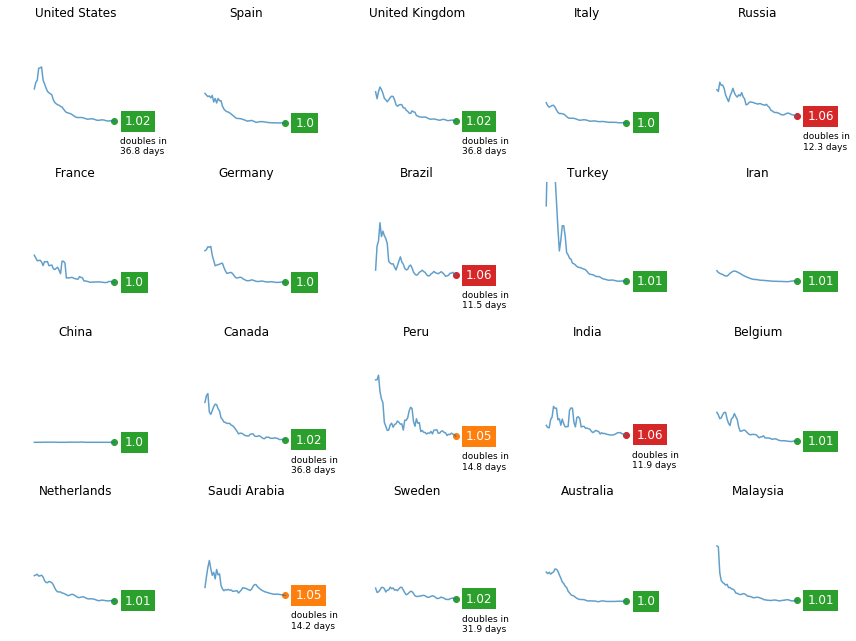

In [25]:
countries = list(latest[:17].country) + ['Sweden','Australia', 'Malaysia']

print(f'\nDay-to-day % growth of new confirmed cases for 8 weeks prior to {date.day} {mdict[date.month]} 2020')
fig, axes = plt.subplots(ncols=5, nrows=round(len(countries)/5), figsize=(12,9), constrained_layout=True)
col = ['growth_avg']
for i, ax in zip(range(len(countries)), axes.flat):
    data = df2[df2.country==countries[i]].iloc[-7*8:].reset_index(drop=True)
    ax.plot(data[col].clip(1)[:], alpha=0.7)
    latest_growth = data[col].iloc[-1]
    if latest_growth[0] < 2**(1/28):
        color = 'C2'
    elif latest_growth[0] < 2**(1/21):
        color = 'C7'
    elif latest_growth[0] < 2**(1/14):
        color = 'C1'
    else: color = 'C3'
    double_days = f'doubles in\n{round(math.log(2)/math.log(latest_growth),1)} days' if latest_growth[0] > 2**(1/(7*6)) else ''
    ax.scatter(data.index.max(), latest_growth, marker='o', color=color)
    #ax.hlines(0,data.index.min(),data.index.max(), alpha=0.1)
    ax.text(data.index.max()+7, latest_growth, str(round(latest_growth[0],2)),
            color='white', ha='left', va='center', size=12, bbox=dict(facecolor=color, edgecolor='none'))
    ax.text(data.index.max()+4, latest_growth-0.2, double_days, ha='left', va='center', size=9)
    ax.set_ylim(0.9, 1.8)
    ax.axis('off')
    ax.set_title(countries[i], fontsize=12)
plt.tight_layout()
plt.savefig('img/growth', pad_inches=0)
plt.savefig(f'img_archive/growth_{str(date)[:10]}', pad_inches=0)
plt.show()

In [26]:
# print('Day-to-day % growth of new confirmed cases over the past 7 days')
# dfgrowth = pd.pivot_table(df2, values=['growth'], index=['country'], columns=['date'], aggfunc='sum').loc[countries]
# dfgrowth.iloc[:,-7:]

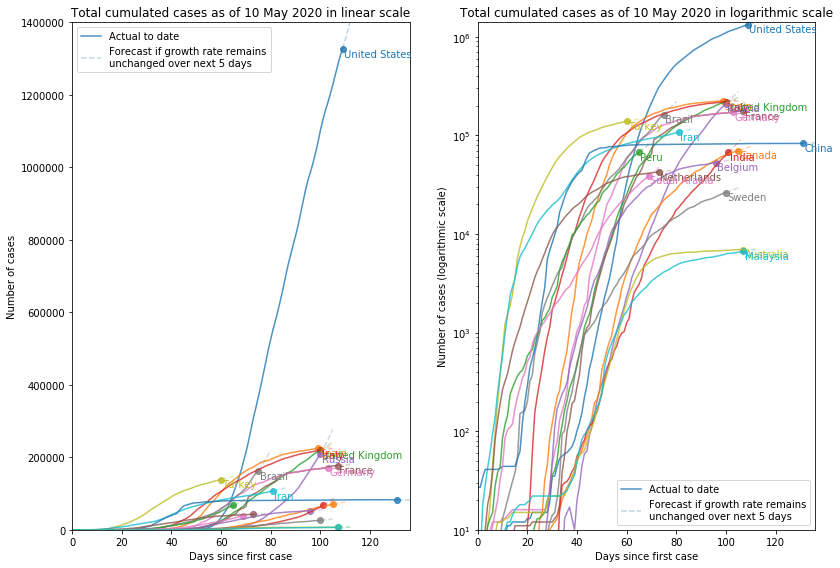

In [27]:
xmax = 45
future_days = 5
ylabels = ['Number of cases', 'Number of cases (logarithmic scale)']
latestdate = f'{date.day} {mdict[date.month]} 2020'
titles = [f'Total cumulated cases as of {latestdate} in linear scale',
          f'Total cumulated cases as of {latestdate} in logarithmic scale']
fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=2) 
for s in range(2): # one for log scale, one for regular scale
    for i, country in enumerate(countries):
        color = f'C{i}' if i < 10 else f'C{str(i)[-1]}'   
        # Data for actual
        data = df2.loc[(df2.country==country), 'confirmed'].reset_index(drop=True)
        ax[s].plot(data, alpha=0.8, color=color, label='Actual to date')
        ax[s].scatter(data.index.max(), data.iloc[-1], alpha=0.8, color=color)
        if s==0:
            if i<10 : ax[s].text(data.index.max()+0.5, data.max(), country,
                                 va='top', ha='left', fontsize=10, color=color)
        else:
            ax[s].text(data.index.max()+0.5, data.max(), country, va='top', ha='left', fontsize=10, color=color)
        # Data for forecast
        latest_growth = df2.loc[(df2.country==country), 'growth'].rolling(window=3).mean().iloc[-1]
        latest_total = df2.loc[(df2.country==country), 'confirmed'].iloc[-1]
        extrapolate = [data.iloc[-1]]
        new_data = latest_total
        for day in range(future_days):
            new_data = new_data * latest_growth
            extrapolate.append(new_data)
        xdays = range(data.index.max(), data.index.max()+future_days+1)
        ax[s].plot(xdays, extrapolate, alpha=0.3, ls='dashed', color=color, label=f'Forecast if growth rate remains\nunchanged over next {future_days} days')
        if i==0: ax[s].legend()
    if s==1: plt.yscale('log')
    ax[s].set_title(titles[s])
    ax[s].set_xlim(0, df2[df2.country=='China'].reset_index().index.max()+5)
    ax[s].set_ylim(10, 1.4e6)
    ax[s].set_ylabel(ylabels[s])
    ax[s].set_xlabel('Days since first case')
plt.tight_layout()
plt.savefig(f'img/total_cases', pad_inches=0)
# plt.savefig(f'img_archive/total_cases_{str(date)[:10]}', pad_inches=0)
plt.show()

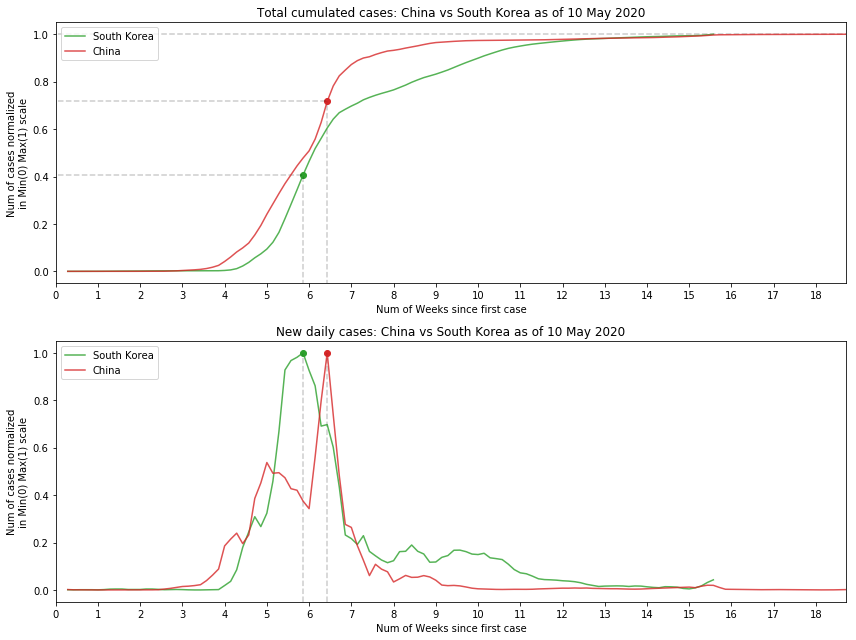

In [28]:
color = ['C2','C3']
cols = ['confirmed','new_confirmed']
titles = ['Total cumulated cases: China vs South Korea as of', 'New daily cases: China vs South Korea as of']
fig, axes = plt.subplots(figsize=(12,9), nrows=2, ncols=1)
for i, ax in zip(range(len(cols)), axes.flat):
    for c, country in enumerate(['South Korea','China']):
        data0 = df2.loc[df2.confirmed > 0]
        data1 = df2.loc[df2.country==country][cols[i]].rolling(window=3).mean().reset_index(drop=True)
        if i==1:
            peakday = data1[data1==data1.max()].index[0]
        else:
            data2 = df2.loc[df2.country==country][cols[i+1]].rolling(window=3).mean().reset_index(drop=True)
            peakday = data2[data2==data2.max()].index[0]
        scaler = MinMaxScaler()
        data = scaler.fit_transform(np.array(data1).reshape(-1, 1))
        ax.plot(data, label=country, color=color[c], alpha=0.8)
        xmax = df2.loc[df2.country=='China'].reset_index().index.max()
        if i==1:
            ax.vlines(peakday, -0.05, 1, linestyle='dashed', alpha=0.2)
            ax.scatter(peakday, 1, marker='o', color=color[c])
        else:
            ax.vlines(peakday, -1, data[peakday], linestyle='dashed', alpha=0.2)
            ax.hlines(data[peakday], -1, peakday, linestyle='dashed', alpha=0.2)
            ax.hlines(1, -1, xmax, linestyle='dashed', alpha=0.1)
            ax.scatter(peakday, data[peakday], marker='o', color=color[c])
        ax.set_title(f'{titles[i]} {latestdate}')
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlim(0, xmax)
        ax.set_xticks(np.array(range(0,xmax,7)))
        ax.set_xticklabels((np.array(range(0,xmax,7))/7).astype(int))
        ax.set_ylabel('Num of cases normalized\nin Min(0) Max(1) scale')
        ax.set_xlabel('Num of Weeks since first case')
        ax.legend(loc='upper left')
        plt.tight_layout()
plt.savefig('img/china_korea', pad_inches=0)
plt.show()

In [29]:
# usa = df4[df4.country=='United States'][['state','confirmed','new_confirmed']].sort_index()
# fig, ax = plt.subplots(figsize=(12,6))
# for state in usa.loc[usa.index.max()].sort_values('confirmed', ascending=False).state[:10]:
#     plt.plot(usa[usa.state==state].new_confirmed.rolling(window=7).mean(), label=state)
# #ax.set_yscale('log')
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
# fig.autofmt_xdate(rotation=90)
# ax.set_xlim(pd.to_datetime('20200315', format='%Y%m%d'), usa.index.max())
# plt.tight_layout()
# plt.legend()
# plt.show()

### 3. Forecasting

In [30]:
# country='United Kingdom'
# rolling=3
# days=300
# fit_start=None
# fit_end=None

# country='Italy'
# rolling=3
# days=270
# fit_start=None
# fit_end='20200319'

# showzero=True
# showpeak=True
# showforecast=True
# A=None
# K=None
# C=None
# Q=None
# B=None
# v=None

# Generalised logistic function (Richard's curve)
def richards(x, A, K, C, Q, B, v):
    y = A + (K-A) / ((C + (Q * np.exp(-1 * B * x))) ** (1/v))
    return y

# Fit to Richard's curve model
def predict_plot(country, rolling=1, fit_start=None, fit_end=None, days=130,
                 showzero=True, showpeak=True, showforecast=True,
                 A=None, K=None, C=None, Q=None, B=None, v=None, df2=df2):

    data = df2.loc[df2.country==country].reset_index(drop=True)
    dates = data.date
    latestdate = dates.iloc[-1]

    # # All dates in raw Actuals
    # dates = df2.loc[df2.country==country].reset_index(drop=True).date
    # # All raw Actuals
    # actual0    = df2.loc[df2.country==country, 'confirmed'].reset_index(drop=True)
    # actual0new = df2.loc[df2.country==country, 'new_confirmed'].reset_index(drop=True)

    # Limit Actual data period for model fit
    oneday = pd.Timedelta(1, unit='days')
    fit_start   = pd.to_datetime(fit_start, format='%Y%m%d')
    fit_end     = pd.to_datetime(fit_end, format='%Y%m%d')
    index_start = list(dates[dates==fit_start].index)[0] if fit_start != None else None
    index_end   = list(dates[dates==fit_end+oneday].index)[0] if fit_end != None else None
    actual1 = data.confirmed.iloc[index_start:index_end]

    # Data for model fit input after rolling average
    dropna = range(actual1.index.min(),actual1.index.min()+(rolling-1))
    actual2 = actual1.rolling(window=rolling).mean().drop(dropna) if rolling > 1 else actual1
    xdata = np.array(range(rolling,len(actual2)+rolling))
    ydata = np.array(actual2.values)

    # Auto fit model
    popt, pcov = curve_fit(richards, xdata, ydata, maxfev=3000)
    # Hyperparams of auto fit
    A0, K0, C0, Q0, B0, v0 = popt

    # Overwrite auto fit hyperparams if manual value exists
    A = A0 if A==None else A
    K = K0 if K==None else K
    C = C0 if C==None else C
    Q = Q0 if Q==None else Q
    B = B0 if B==None else B
    v = v0 if v==None else v

    # Calculate prediction over required num of days
    xdata2 = np.array(range(days))
    predcalc = richards(xdata2, A, K, C, Q, B, v)
    pred_index = range(actual2.index.min(), days+actual2.index.min())

    # Forecast dates that overlap with Actuals
    predict_dates1 = list(filter(lambda row: row <= dates.index.max(), pred_index))
    dates_part_1 = []
    for dy in predict_dates1:
        dates_part_1.append(dates.loc[dy]) 
    predict1 = pd.DataFrame(predcalc[:len(dates_part_1)], columns=['predict'], index=pred_index[:len(dates_part_1)]).clip(0)
    data = data.join(predict1)

    # Forecast dates beyond Actuals period
    predict_dates2 = list(filter(lambda row: row > dates.index.max(), pred_index))
    dates_part_2 = []
    for ix in range(len(predict_dates2)):
        dates_part_2.append(dates.max() + oneday * (ix+1))
    predict2 = pd.DataFrame(predcalc[len(dates_part_1):], columns=['predict'], index=pred_index[len(dates_part_1):])
    predict2['date'] = dates_part_2
    predict2['country'] = country

    # Combine both tables
    data = pd.concat([data, predict2])
    # Shift prediction time for rolling avg and remove final nan rows
    data.predict = data.predict.shift(-1*(rolling+1))
    data = data[:-1*(rolling+1)]
    # Calc new cases & growth
    data.predict = data.predict.fillna(-1)
    data.predict = data.predict.astype(int)
    data.predict = data.predict.replace(-1, np.nan)
    data['new_predict'] = data.predict.diff()
    data['new_conf_avg_7'] = round(data.new_confirmed.rolling(window=7).mean())
    data['temp_conf'] = data.apply(lambda row: row.predict if pd.isnull(row.confirmed) else row.confirmed, axis=1)
    data['temp_new'] = data.temp_conf.diff()
    data['new_pred_avg_7'] = round(data.temp_new.rolling(window=7).mean())
    data['p_growth'] = np.nan
    for i in data.index:
        data.iloc[i, data.columns.get_loc('p_growth')] = 0 if data.iloc[i-1].predict == 0 else round(data.iloc[i].predict/data.iloc[i-1].predict,3).clip(1)    
    data['p_gr_avg_7'] = round(data.p_growth.rolling(window=7).mean(),3).clip(1)
    data = data[['date', 'country',
                 'confirmed', 'new_confirmed', 'new_conf_avg_7', 'growth', 'growth_avg_7',
                 'predict', 'new_predict', 'new_pred_avg_7', 'p_growth', 'p_gr_avg_7']]

    # Save df in csv
    data.to_csv(f"data/dfdata/forecast_{country.replace(' ','_')}.csv")
    data.to_csv(f"data/archive/forecast_{country.replace(' ','_')}_{str(latestdate)[:10]}.csv")

    # Find dates for plot labels
    # Latest available date in raw Actual
    latestindex = data[data.confirmed.isnull()].index.min()-1
    latestdate  = data.date.iloc[latestindex]

    # Date of plateau
    oneday = pd.Timedelta(1, unit='days')
    zeroindex = data.iloc[latestindex:][data.iloc[latestindex:].new_predict < 0.5].index.min()
    to_zero_days  = zeroindex - latestindex
    to_zero_weeks = round(to_zero_days/7)
    zerodate = latestdate + oneday*to_zero_days
    if (to_zero_days < 5) | (np.isnan(zeroindex)): showpeak = False

    # Date of peak
    peakindex = data[data.new_predict==data.new_predict.max()].index[0]
    to_peak_days  = peakindex - latestindex
    to_peak_weeks = round(to_peak_days/7)
    peakdate = latestdate + oneday*to_peak_days
    if to_peak_days < 5: showpeak = False

    # Plot prediction
    fig, ax = plt.subplots(figsize=(12,5), ncols=2, nrows=1)
    mdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    if showforecast==True:
        ax[0].plot(data.date, data.predict,  ls='dashed', c='C1', label='Forecast')
        ax[1].plot(data.date, data.new_predict, ls='dashed', c='C1', label='Forecast')

    # Plot actual
    value_latest = data.confirmed.iloc[latestindex]
    value_latest_new = data.new_confirmed.iloc[latestindex]
    ax[0].plot(data.date, data.confirmed, c='C0', label='Actual to date')
    ax[0].scatter(latestdate, int(value_latest), c='C0')
    ax[0].text(latestdate+oneday*2, value_latest, f'{latestdate.day} {mdict[latestdate.month]}\n{format(int(value_latest), ",")} cases', va='top')
    ax[1].plot(data.date, data.new_confirmed, c='C0', label='Actual daily')
    ax[1].scatter(latestdate, int(value_latest_new), color='C0')
    ax[1].text(latestdate+oneday*2, value_latest_new, f'{latestdate.day} {mdict[latestdate.month]}\n{format(int(value_latest_new), ",")} cases', va='top')

    # Plot prediction end points
    if showforecast==True:
        if (showzero==True) & (pd.isna(to_zero_days)==False) :
            ax[0].scatter(zerodate, data.predict.max(), c='C1')      
            predictmax = int(math.ceil(data.predict.max()/100.0))*100 if data.predict.max() > value_latest else int(math.ceil(value_latest/100.0))*100
            zerolabel = f"{int(round(to_zero_weeks))} week{'s' if to_zero_weeks>1 else ''}"
            ax[0].text(zerodate+oneday*2, predictmax, f"{zerodate.day} {mdict[zerodate.month]}\n{format(predictmax, ',')} cases\nin {zerolabel}", va='top')
        if (showpeak==True) & (pd.isna(to_peak_days)==False):
            ax[1].scatter(peakdate, data.new_predict.max(), c='C1')
            peaklabel = f"{int(round(to_peak_weeks))} week{'s' if to_peak_weeks>1 else ''}"
            ax[1].text(peakdate+oneday*2, data.new_predict.max(), f"{peakdate.day} {mdict[peakdate.month]}\nin {peaklabel}", va='top')

    if showforecast==False:
        ax[0].text(data.date.iloc[0] + oneday*days/2, (data.confirmed.min()+data.confirmed.max())/2, 'Latest forecast\nto be reviewed', bbox=dict(facecolor='none', edgecolor='C1', linewidth=2, linestyle='dashed'), ha='center')
        ax[1].text(data.date.iloc[0] + oneday*days/2, (data.new_confirmed.min()+data.new_confirmed.max())/2, 'Latest forecast\nto be reviewed', bbox=dict(facecolor='none', edgecolor='C1', linewidth=2, linestyle='dashed'), ha='center')

    # Plot titles and axis
    ax[0].set_title(f'{country.upper()}\nTotal cumulated cases')
    ax[0].set_ylabel('Num of cumulative cases')    
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax[0].legend(loc='lower right' if showforecast==True else 'center right')

    ax[1].set_title(f'{country.upper()}\nNew daily cases')
    ax[1].set_ylabel('Num of new daily cases')
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax[1].legend(loc='lower right' if showforecast==True else 'center right')

    if showforecast==False:
        ax[0].set_xlim(dates.values[0], dates.values[0] + oneday * days)
        ax[1].set_xlim(dates.values[0], dates.values[0] + oneday * days)

    fig.autofmt_xdate(rotation=90)
    plt.tight_layout()
    plt.savefig(f"img/forecast_{country.replace(' ','_')}_latest", pad_inches=0)
    #plt.savefig(f"img_archive/forecast_{country.replace(' ','_')}_{str(latestdate)[:10]}", pad_inches=0)    
    plt.show()

    print(country)
    print(f'Auto fit  : A={int(A0)}, K={int(K0)}, C={round(C0,4)}, Q={round(Q0,4)}, B={round(B0,4)}, v={round(v0,4)}')
    if (A!=A0) | (K!=K0) | (C!=C0) | (Q!=Q0) | (B!=B0) | (v!=v0):
        print(f'Manual fit: A={int(A)}, K={int(K)}, C={round(C,4)}, Q={round(Q,4)}, B={round(B,4)}, v={round(v,4)}')

In [31]:
def plot_forecasts(country, fdates, days=200):
    fig, ax = plt.subplots(figsize=(12,5), nrows=1, ncols=2)
    titles = ['Total cumulated cases', 'New daily cases']
    ylabels = ['Num of cumulated cases', 'Num of new daily cases']
    for n in [0,1]:

        # Plot actual
        col = 'confirmed' if n==0 else 'new_confirmed'
        data0 = pd.read_csv(f"data/dfdata/forecast_{country.replace(' ','_')}.csv", index_col=1).iloc[:,1:]
        data0.index = pd.to_datetime(data0.index)
        actualmax = data0[data0.confirmed>0].index.max()
        ax[n].plot(data0[col], lw=2, label=f'Actual as of {str(actualmax)[8:10]} {mdict[int(str(actualmax)[5:7])]}')
        ax[n].scatter(actualmax, data0[col].loc[actualmax])
        xmin = data0.index.min()
        xmax = data0.index.min()+oneday*days
        shift = (xmax-xmin)*0.02
        ax[n].text(actualmax+shift, data0[col].loc[actualmax], format(int(data0[col].loc[actualmax]),","), va='center')

        # Plot forecast
        col = 'predict' if n==0 else 'new_predict'
        for i, fdate in enumerate(fdates):
            color = f'C{i}'
            txtcolor = 'black' if i==0 else color
            alpha = 1 if i==0 else 0.5
            data1 = pd.read_csv(f"data/archive/forecast_{country.replace(' ','_')}_{fdate}.csv", index_col=1).iloc[:,1:]
            data1.index = pd.to_datetime(data1.index)
            label = f"Forecast as of {str(fdate)[-2:]} {mdict[int(str(fdate)[5:7])]}"
            ax[n].plot(data1[col], ls='dashed', alpha=alpha, label=label, color=color)
            if n==0:
                ax[n].text(xmax-shift, data1[col].iloc[-1], format(int(round(data1[col].iloc[-1],-2)), ","), va='center', ha='right', color=txtcolor)

        ax[n].set_title(f'{country.upper()}\n{titles[n]}')
        ax[n].set_xlim(data0.index.min(),xmax)    
        ax[n].set_ylabel(ylabels[n])
        ax[n].legend()
        ax[n].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))

    fig.autofmt_xdate(rotation=90)
    plt.tight_layout()
    plt.savefig(f"img/forecast_{country.replace(' ','_')}", pad_inches=0) 
    plt.show()

**Instructions on how to run the model**

In [32]:
# Use predict_plot function to run model by country:
#
# predict_plot('United Kingdom',                         # compulsory
#              rolling=1,                                # optional: number of period of moving avg if > 1
#              fit_start='20200311', fit_end='20200311', # optional: but essential if converge error
#              days=110,                                 # optional: number of days to plot (default 110)
#              A=.., K=.., C=.., Q=.., B=.., v=..        # optional: manual tweak of Richard's curve parameters
#              showzero=True, showpeak=True)             # optional: show or hide date of plateau or peak
#
# 1. Run the function with predict_plot(country)
#
# 2. If error message "Optimal parameters not found" is generated, this means that
#    data points can't be fit into a curve due to failure to converge after 3000 iterations
#
# 3. In case of such error, change fit_start or/and fit_end (dates) and/or rolling period (days)
#    manually until the error disappears and a resonable result is generated.
#
# 4. If the curve overfits and/or it doesn't follow the expected result, tweak A/K/C/Q/B/v
#    parameters manually. Use the auto-generated parameter values shown underneath the plots
#    as a starting point and refer to be guide below on the effect of changing these parameters.

![title](img/richards_curve_params.png)

In [33]:
fdates = ['2020-04-25','2020-04-18','2020-04-11','2020-04-03']

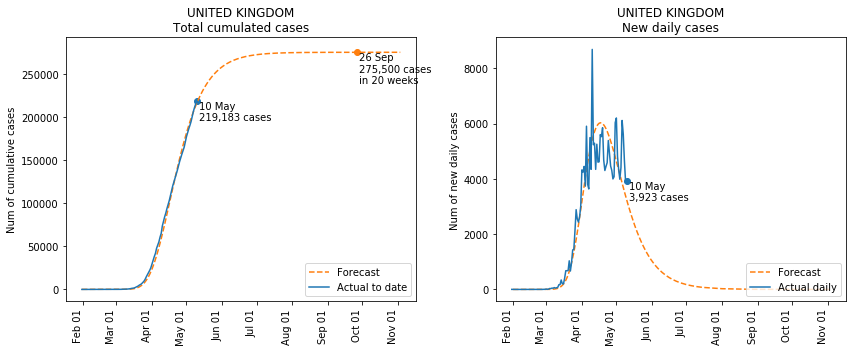

United Kingdom
Auto fit  : A=101, K=166, C=0.661, Q=4.0851, B=0.0645, v=0.0506
Manual fit: A=90, K=166, C=0.661, Q=4.0851, B=0.061, v=0.0506


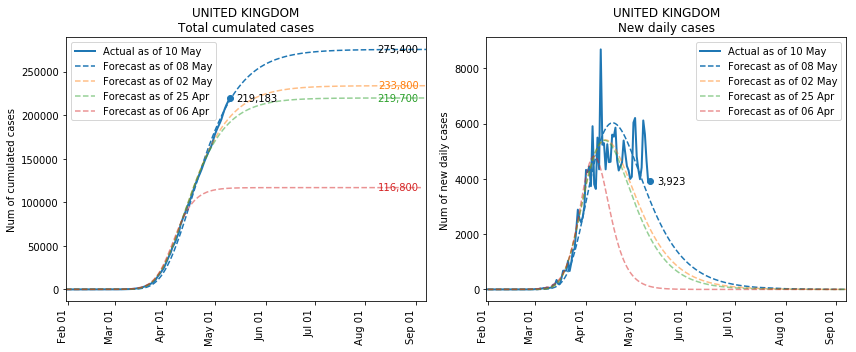

In [34]:
# predict_plot('United Kingdom', days=50, fit_start='20200311', fit_end='20200321')
# predict_plot('United Kingdom', days=50, fit_start='20200317', fit_end='20200329', Q=0.00013)
# predict_plot('United Kingdom', days=120, fit_start='20200317', fit_end='20200329', A=60000, Q=0.00005, showforecast=False)
predict_plot('United Kingdom', fit_end='20200428', days=280, rolling=2, A=90, B=0.061)
plot_forecasts('United Kingdom', ['2020-05-08','2020-05-02','2020-04-25','2020-04-06'], days=220)

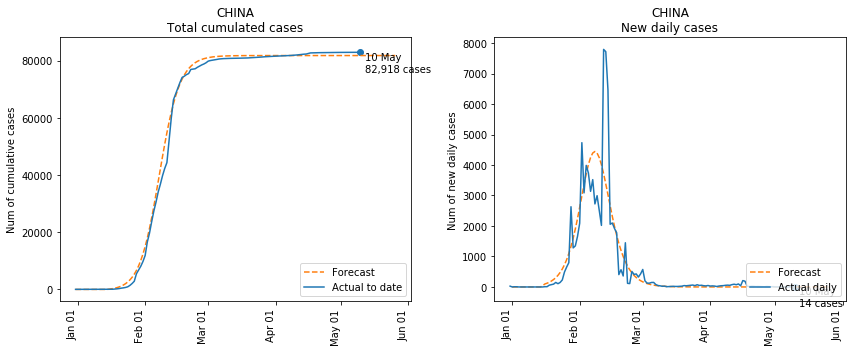

China
Auto fit  : A=-326, K=193, C=0.011, Q=46.93, B=0.2094, v=0.8917


In [35]:
predict_plot('China', days=150, showzero=False)

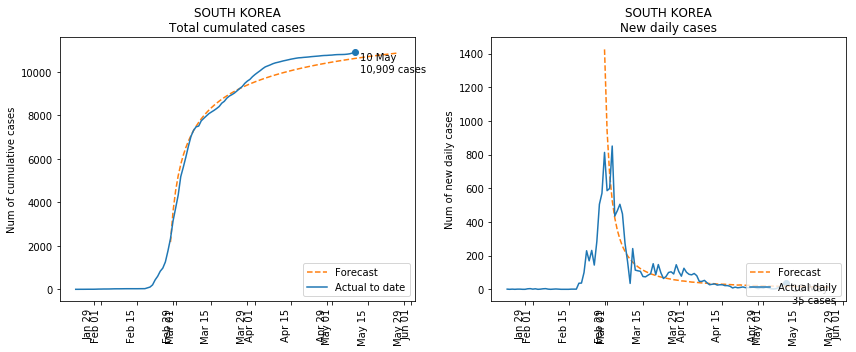

South Korea
Auto fit  : A=11846, K=9076, C=-0.9895, Q=1.0573, B=-0.0259, v=2.1537


In [36]:
#predict_plot('South Korea', rolling=0, days=50, showzero=False, fit_end='20200323')
#predict_plot('South Korea', days=70, showzero=False, fit_start='20200301', fit_end='20200326')
predict_plot('South Korea', days=90, showzero=False, fit_start='20200301', fit_end='20200328')

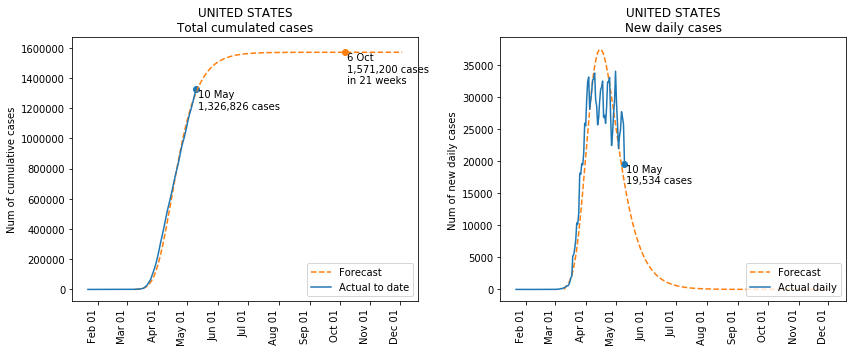

United States
Auto fit  : A=-66, K=1469, C=0.5126, Q=0.6573, B=0.0891, v=0.1028
Manual fit: A=-900, K=1469, C=0.5126, Q=0.6573, B=0.068, v=0.1028


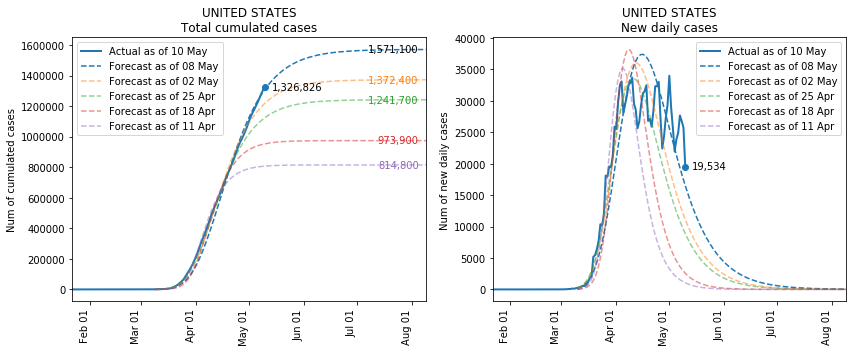

In [37]:
#predict_plot('United States', fit_start='20200311', fit_end='20200325', days=120, B=0.2, K=3000, Q=2)
#predict_plot('United States', fit_start='20200311', fit_end='20200325', days=160, B=0.13, K=5000, Q=2)
#predict_plot('United States', fit_start='20200311', fit_end='20200325', days=180, B=0.118, K=5700, Q=2.2)
#predict_plot('United States', fit_start='20200311', fit_end='20200330', days=260, A=-150, B=0.077)
#predict_plot('United States', fit_start='20200311', fit_end='20200416', days=270, rolling=2, A=-600, B=0.075)
predict_plot('United States', fit_start='20200311', fit_end='20200416', days=270, rolling=2, A=-900, B=0.068)
plot_forecasts('United States', ['2020-05-08','2020-05-02','2020-04-25','2020-04-18','2020-04-11'], days=200)

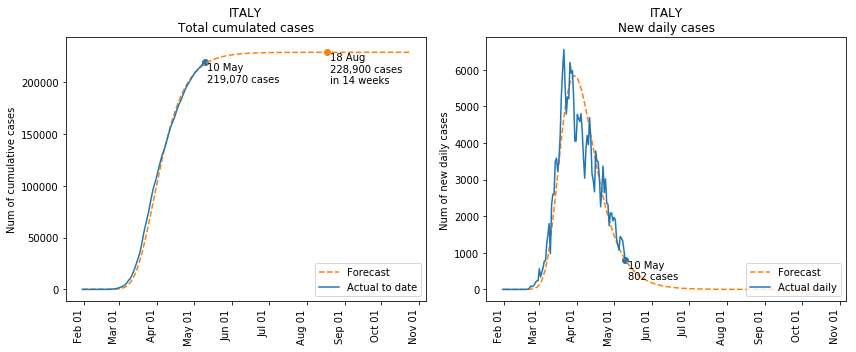

Italy
Auto fit  : A=206, K=257, C=0.686, Q=2.2382, B=0.0759, v=0.0455
Manual fit: A=199, K=257, C=0.686, Q=2.2382, B=0.071, v=0.0455


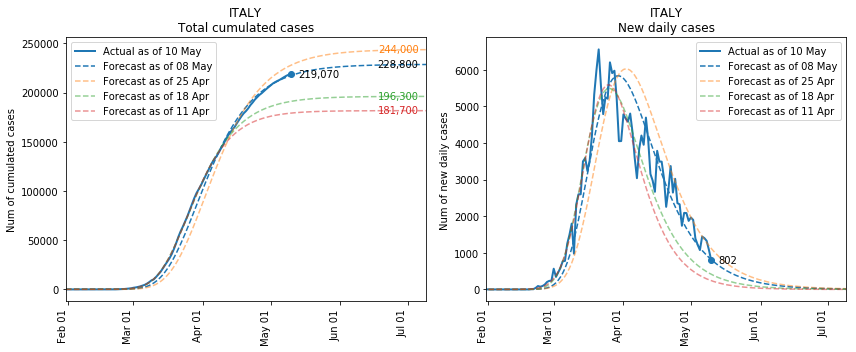

In [38]:
#predict_plot('Italy', days=270, showpeak=False, fit_end='20200319')
#predict_plot('Italy', days=270, rolling=3, fit_end='20200415', A=50, B=0.07)
predict_plot('Italy', days=270, rolling=3, fit_end='20200415', A=199, B=0.071)
plot_forecasts('Italy', ['2020-05-08','2020-04-25','2020-04-18','2020-04-11'], days=160)

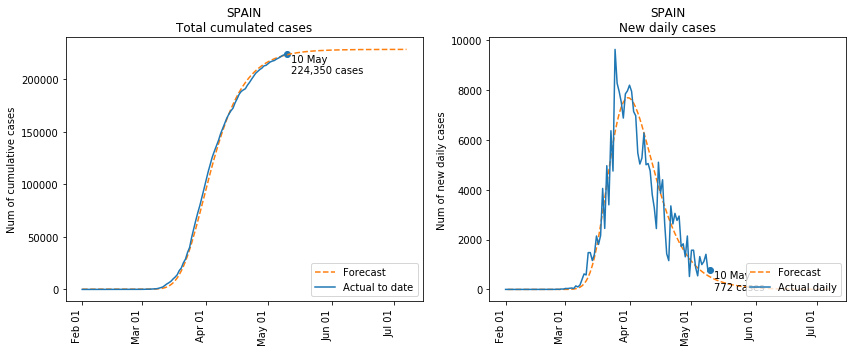

Spain
Auto fit  : A=242, K=319, C=0.6557, Q=10.5379, B=0.0962, v=0.0531
Manual fit: A=239, K=319, C=0.6557, Q=10.5379, B=0.094, v=0.0531


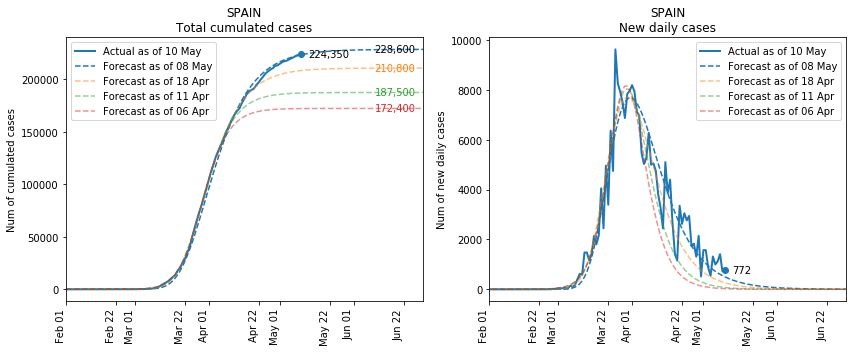

In [39]:
#predict_plot('Spain', days=70, fit_start='20200313', fit_end='20200323')
#predict_plot('Spain', days=70, fit_start='20200314', fit_end='20200329')
#predict_plot('Spain', days=70, fit_start='20200316', fit_end='20200329', A=120000, Q=0.00005)
#predict_plot('Spain', days=160, rolling=3, fit_end='20200420', A=190, B=0.09)
predict_plot('Spain', days=160, rolling=3, fit_end='20200427', A=239, B=0.094)
plot_forecasts('Spain', ['2020-05-08','2020-04-18','2020-04-11','2020-04-06'], days=150)

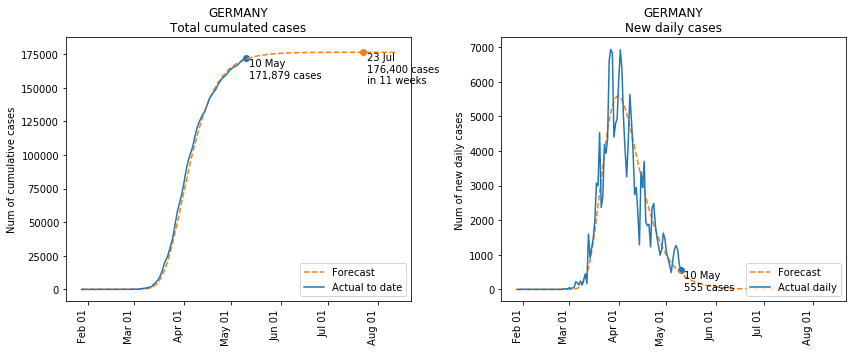

Germany
Auto fit  : A=140, K=165, C=0.6925, Q=8.8253, B=0.091, v=0.0416
Manual fit: A=140, K=165, C=0.6925, Q=8.8253, B=0.088, v=0.0416


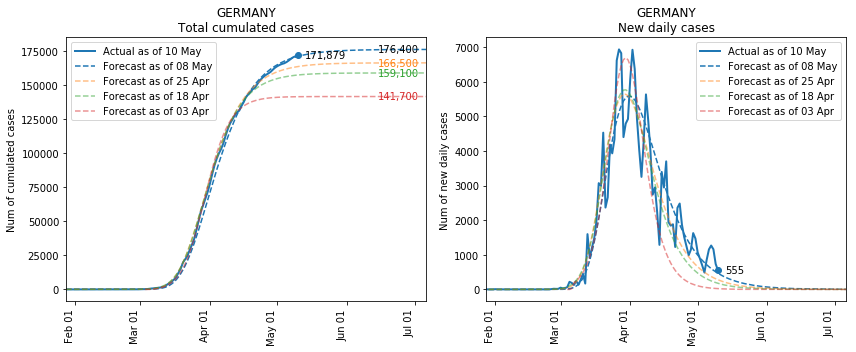

In [40]:
#predict_plot('Germany', rolling=1, days=140, fit_start='20200303', fit_end='20200317', A=-700, B=0.17)
predict_plot('Germany', rolling=2, days=200, fit_end='20200430', A=140, B=0.088)
plot_forecasts('Germany', ['2020-05-08','2020-04-25','2020-04-18','2020-04-03'], days=160)

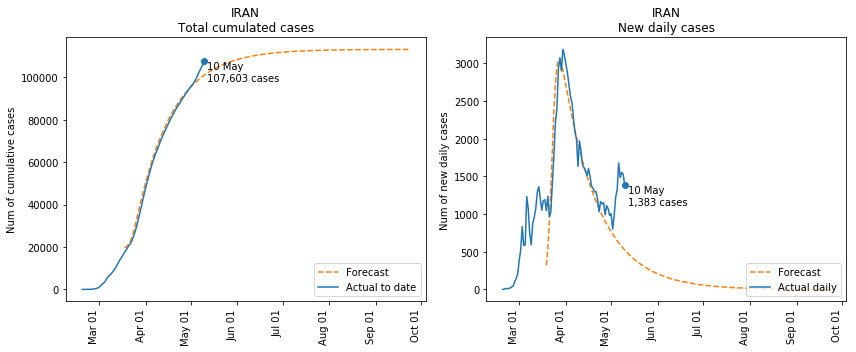

Iran
Auto fit  : A=113205, K=17927, C=1.2227, Q=0.0795, B=-0.5997, v=14.201


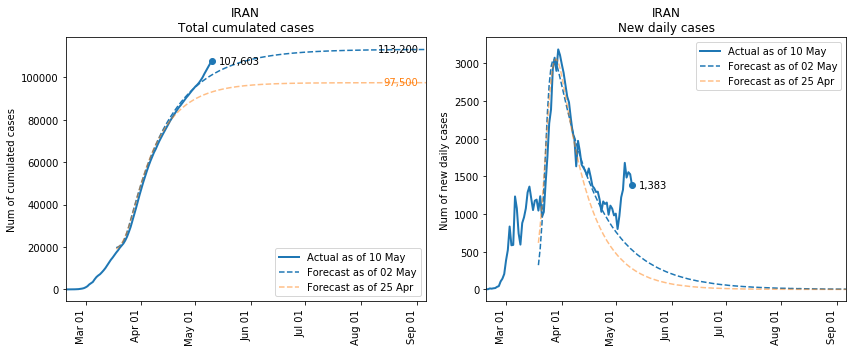

In [41]:
#predict_plot('Iran', days=120, fit_end='20200401', showforecast=False)
#predict_plot('Iran', days=200, fit_start='20200307', fit_end='20200321', B=-0.7, v=12)
#predict_plot('Iran', days=200, fit_start='20200309', fit_end='20200321')
#predict_plot('Iran', fit_start='20200320', fit_end='20200414', days=190)
predict_plot('Iran', fit_start='20200320', fit_end='20200429', days=190)
plot_forecasts('Iran', ['2020-05-02','2020-04-25'])

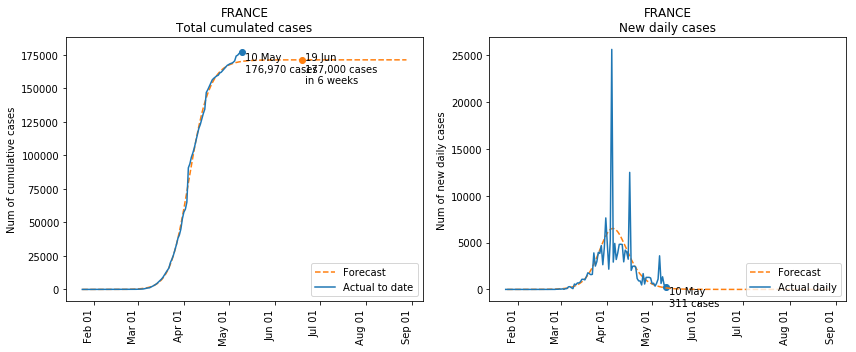

France
Auto fit  : A=-36, K=585, C=0.015, Q=326.97, B=0.1403, v=0.7472


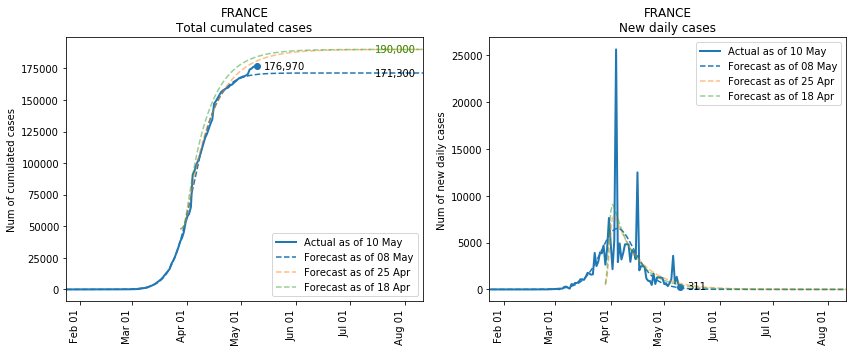

In [42]:
#predict_plot('France', days=130, fit_start='20200314', fit_end='20200412', A=-5000, B=0.32)
#predict_plot('France', days=170, rolling=2, A=-265, B=0.24, Q=160)
#predict_plot('France', days=180, fit_start='20200330', fit_end='20200415', A=190000, B=-1.3)
predict_plot('France', days=220, fit_end='20200505', rolling=3)
plot_forecasts('France', ['2020-05-08','2020-04-25','2020-04-18'])

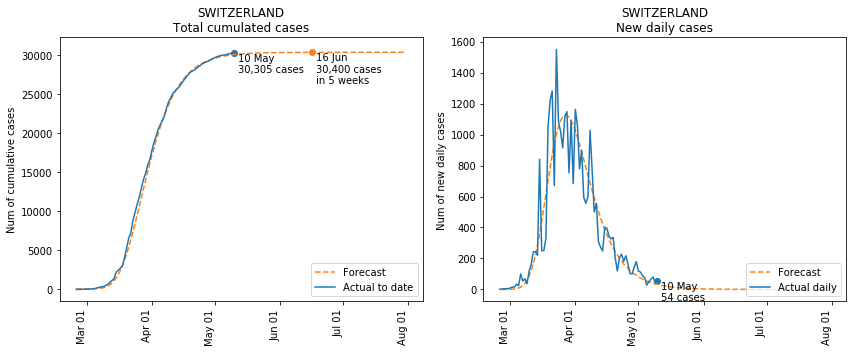

Switzerland
Auto fit  : A=95, K=486, C=0.709, Q=1.803, B=0.1104, v=0.0802
Manual fit: A=70, K=486, C=0.709, Q=1.803, B=0.105, v=0.0802


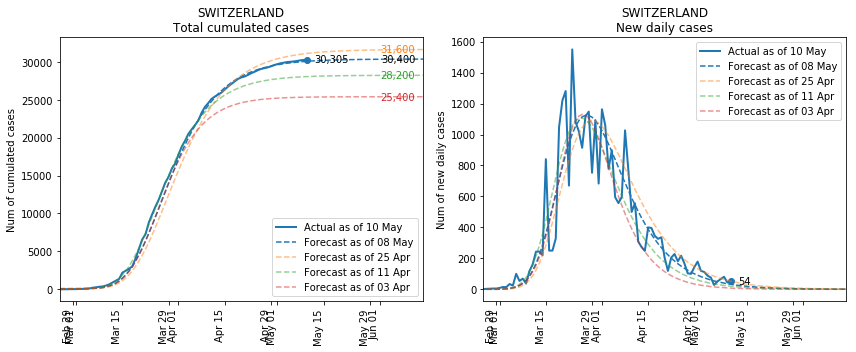

In [43]:
#predict_plot('Switzerland', days=75, fit_end='20200328', K=240, A=-900)
predict_plot('Switzerland', days=160, fit_end='20200409', rolling=3, A=70, B=0.105)
plot_forecasts('Switzerland', ['2020-05-08','2020-04-25','2020-04-11','2020-04-03'], days=110)

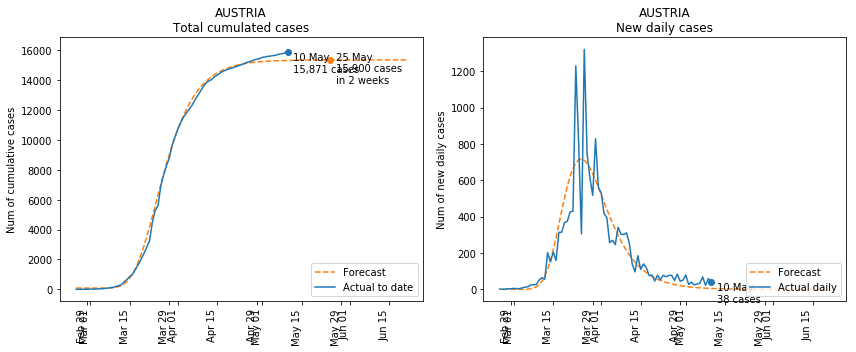

Austria
Auto fit  : A=84, K=135, C=0.7581, Q=1.9533, B=0.1309, v=0.0485


In [44]:
predict_plot('Austria', fit_end='20200501', days=120, rolling=2)

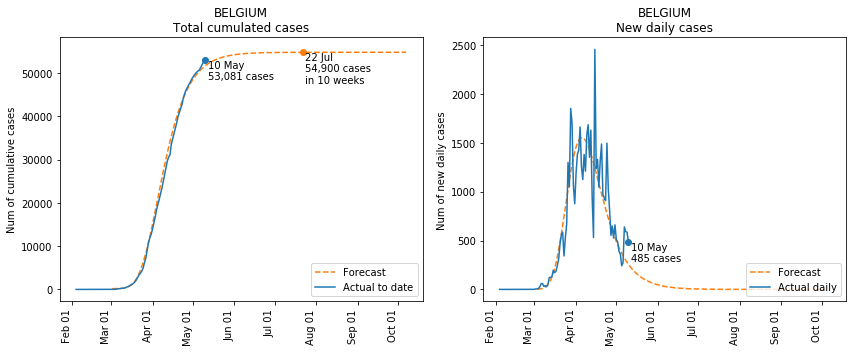

Belgium
Auto fit  : A=203, K=381, C=0.6621, Q=0.7325, B=0.0841, v=0.0736
Manual fit: A=180, K=381, C=0.6621, Q=0.7325, B=0.08, v=0.0736


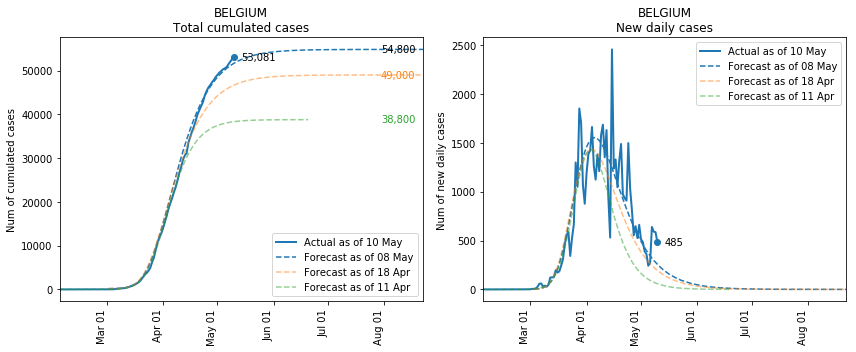

In [45]:
#predict_plot('Belgium', days=100, fit_start='20200304', A=-120)
#predict_plot('Belgium', days=220, fit_start='20200304', fit_end='20200413', A=180, B=0.063)
predict_plot('Belgium', days=220, fit_start='20200304', fit_end='20200414', A=180, B=0.08)
plot_forecasts('Belgium', ['2020-05-08','2020-04-18','2020-04-11'])

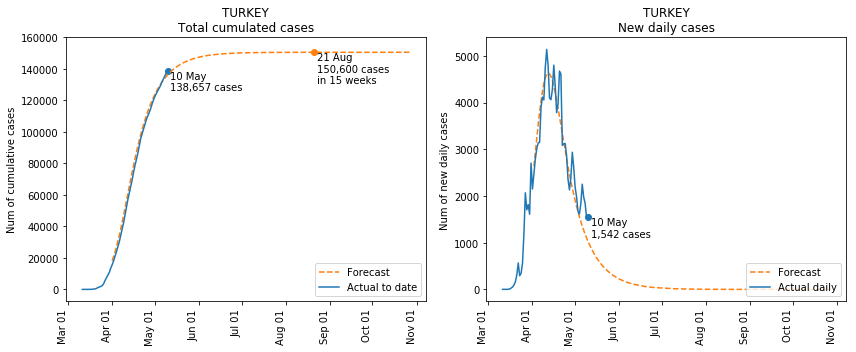

Turkey
Auto fit  : A=150585, K=2942, C=0.9771, Q=0.3628, B=-0.1862, v=2.6805


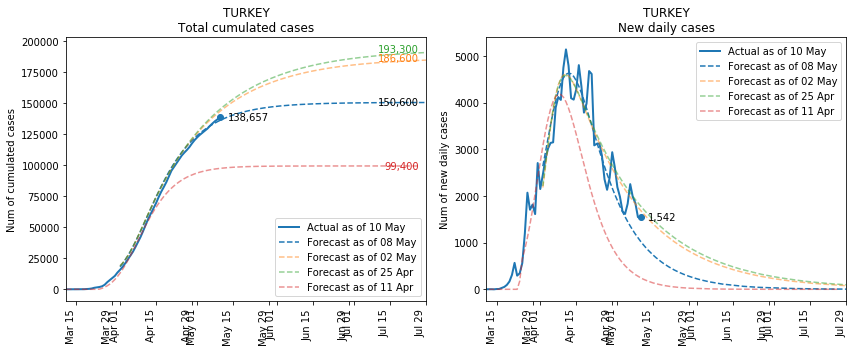

In [46]:
#predict_plot('Turkey', days=140, fit_end='20200403', A=-1500, B=0.123)
predict_plot('Turkey', days=210, fit_start='20200403', fit_end='20200501')
plot_forecasts('Turkey', ['2020-05-08','2020-05-02','2020-04-25','2020-04-11'], days=140)

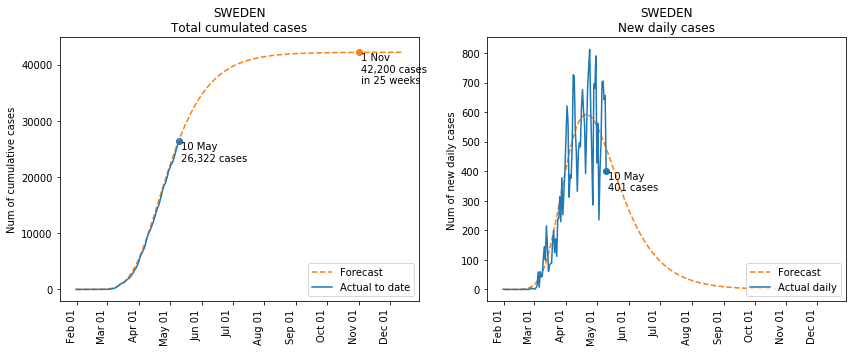

Sweden
Auto fit  : A=-3, K=17, C=0.7616, Q=0.6643, B=0.0388, v=0.0357


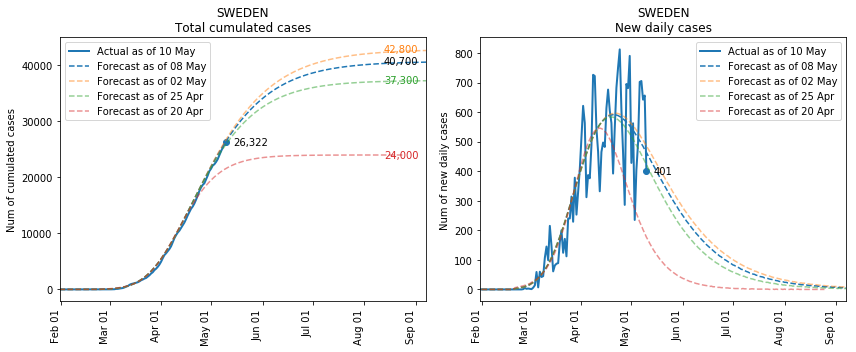

In [48]:
predict_plot('Sweden', fit_end='20200509', days=320)
plot_forecasts('Sweden', ['2020-05-08','2020-05-02','2020-04-25','2020-04-20'], days=220)

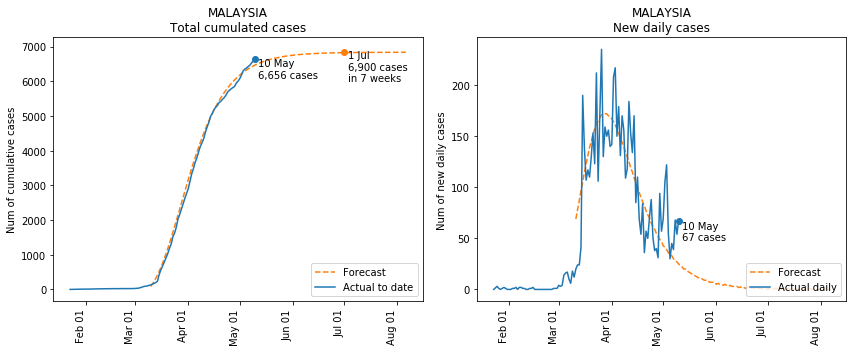

Malaysia
Auto fit  : A=-256, K=-235, C=0.7552, Q=0.1188, B=0.0675, v=0.0481


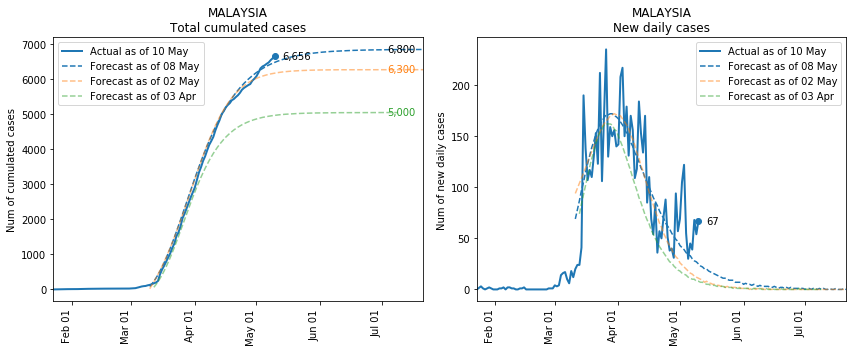

In [49]:
#predict_plot('Malaysia', days=60, fit_start='20200307', fit_end='20200320', K=300, B=0.3, Q=5)
#predict_plot('Malaysia', days=90, fit_start='20200307', fit_end='20200320', K=400, B=0.2, Q=4)
#predict_plot('Malaysia', days=100, fit_start='20200313', fit_end='20200325')
#predict_plot('Malaysia', days=150, fit_start='20200312', fit_end='20200401', A=-550, B=0.08)
predict_plot('Malaysia', days=150, fit_start='20200312', fit_end='20200507')
plot_forecasts('Malaysia', ['2020-05-08','2020-05-02','2020-04-03'], days=180)

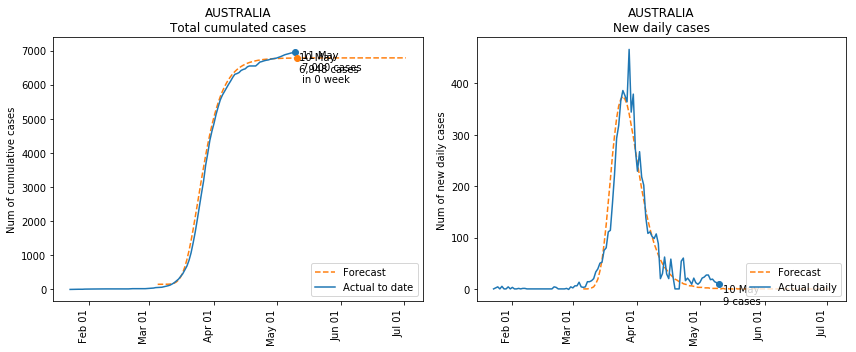

Australia
Auto fit  : A=150, K=197, C=0.7318, Q=1.0106, B=0.1583, v=0.0632


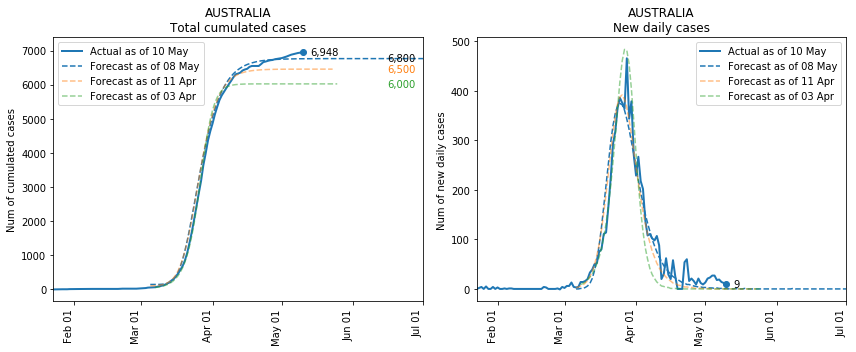

In [50]:
#predict_plot('Australia', days=60, fit_end='20200317', B=0.25, showpeak=False)
#predict_plot('Australia', days=80, fit_start='20200307', fit_end='20200317', showpeak=False, B=0.28, K=300, Q=12)
#predict_plot('Australia', days=80, fit_start='20200307', fit_end='20200328', A=15, B=0.32)
predict_plot('Australia', days=120, fit_start='20200307')
plot_forecasts('Australia', ['2020-05-08','2020-04-11','2020-04-03'], days=160)

In [51]:
# predict_plot('Singapore', days=150, fit_start='20200315', fit_end='20200418', showforecast=None)

### 4. Impact of lockdown on growth

In [52]:
lockdates = {'China':         {'start':'20200123', 'end':'20200327'},
             'Switzerland':   {'start':'20200316', 'end':None},
             'Italy':         {'start':'20200307', 'end':None},
             'Austria':       {'start':'20200316', 'end':None},
             'France':        {'start':'20200317', 'end':None},
             'Belgium':       {'start':'20200318', 'end':None},
             'Malaysia':      {'start':'20200318', 'end':None},
             'Spain':         {'start':'20200320', 'end':None},
             'United States': {'start':'20200320', 'end':None},
             'Canada':        {'start':'20200321', 'end':None},
             'Germany':       {'start':'20200322', 'end':None},
             'United Kingdom':{'start':'20200323', 'end':None},
             'Australia':     {'start':'20200331', 'end':None},
             'Thailand':      {'start':'20200402', 'end':None},
             'Singapore':     {'start':'20200407', 'end':None},
             'Japan':         {'start':'20200406', 'end':None},
             'Indonesia':     {'start':'20200410', 'end':None}
            }

In [53]:
def plot_new_vs_cumulative(countries, xlim, ylim, figsize=(12,11)):
    fig, ax = plt.subplots(figsize=figsize)
    for country in countries:
        data = df1[(df1.country==country)&(df1.confirmed>=100)].sort_index()
        plt.plot(data.confirmed, data.new_confirmed.rolling(window=14).mean().clip(0)+1, label=country, alpha=0.5)
        plt.scatter(data.confirmed[-1].clip(0), data.new_confirmed.rolling(window=14).mean().clip(0)[-1], alpha=0.7)
        plt.text(data.confirmed[-1].clip(0)*1.06, data.new_confirmed.rolling(window=14).mean().clip(0)[-1], country,
                 va='center', fontsize=9, alpha=0.9) #ccodes.loc[country].ccode3
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    from matplotlib.ticker import ScalarFormatter
    ax.tick_params(labelright=True, right=True, which='both')
    yticks = [10,50,100,200,300,400,500,1000,2000,3000,4000,5000,
              10000,20000,30000,40000,50000,100000,200000,800000]
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_yticks(yticks)
    xticks = [1000,10000,100000,500000]
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xticks(xticks)
    
    ax.set_xlabel('Total Cumulative cases')
    ax.set_ylabel('Daily New cases (7-day average)')
    ax.set_title('Total Cumulative cases vs. New Daily Cases')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.tight_layout()

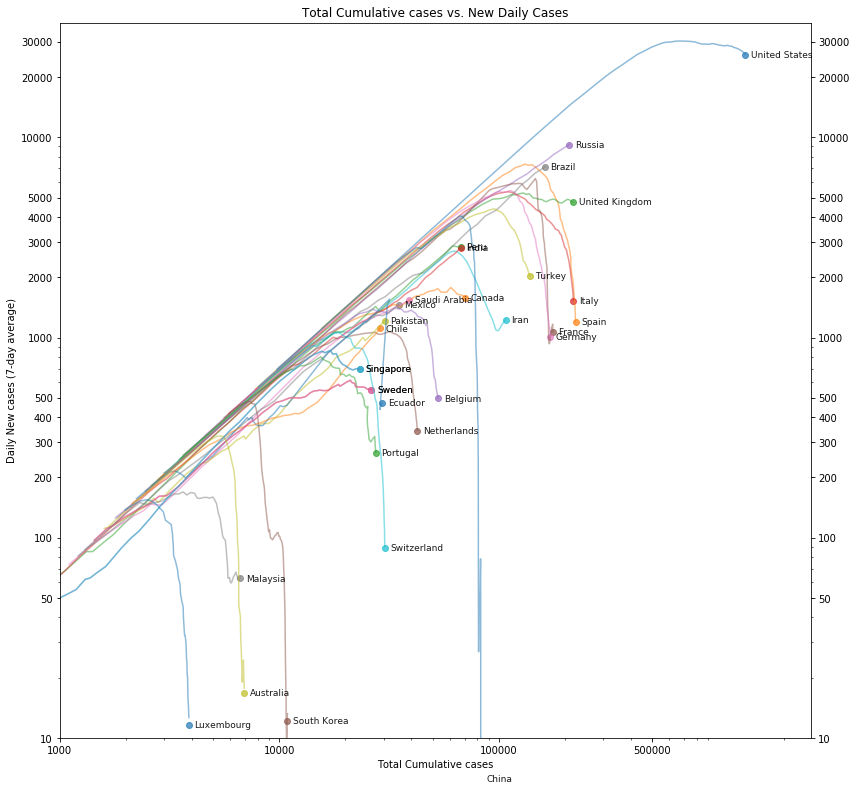

In [54]:
countries2 = ['South Korea', 'Sweden', 'Malaysia', 'Australia', 'Singapore', 'Luxembourg']
countries  = list(df1.loc[df1.index.max()].country[:25]) + countries2
plot_new_vs_cumulative(countries, figsize=(12,11),
                       xlim=[1e3, df1.confirmed.max()*2], ylim=[10, df1.new_confirmed.max()*1.1])

In [55]:
# countries  = list(df1.loc[df1.index.max()].country[1:9])
# plot_new_vs_cumulative(countries, figsize=(8,6.5),
#                        xlim=[7e4, 3e5], ylim=[800, 8000])

In [56]:
def plot_act_fct(countries, measures, yminymax, label, log=True):
    latestdate = df1.index.max()
    datelabel = f'{latestdate.day} {mdict[latestdate.month]} 2020'
    xmin, xmax = latestdate-oneday*28, latestdate+oneday*28
    #xmin, xmax = pd.to_datetime('20200315', format='%Y%m%d'), pd.to_datetime('20200515', format='%Y%m%d')
    fig, ax = plt.subplots(figsize=(12,10))
    for c, country in enumerate(countries):
        if country in list(lockdates.keys()):
            lockstart = lockdates[country]['start']
            lockend   = lockdates[country]['end'] if lockdates[country]['end']!=None else latestdate
        else: lockstart, lockend = None, None
        color = f'C{c}' if c < 10 else f'C{str(c)[-1]}'
        filename = f"data/dfdata/forecast_{country.replace(' ','_')}.csv"
        data = pd.read_csv(filename, index_col=0).set_index('date')
        data = data[data.country==country]
        data.index = pd.to_datetime(data.index)
        # Plot before lockdown
        ax.plot(data.loc[:lockstart][measures[0]].clip(1), color=color, ls='-.', alpha=0.3,
                label='Actual: Before lockdown period')
        # Plot lockdown
        if lockstart != None: ax.plot(data.loc[lockstart:lockend][measures[0]].clip(1), color=color, alpha=0.3,
                                     label='Actual: During lockdown period')
        # Plot after lockdown
        if lockend != None: ax.plot(data.loc[lockend:][measures[0]].clip(1), color=color, ls='-.', alpha=0.3,
                                    label='Actual: After lockdown period')
        # Plot latest
        ax.scatter(latestdate, data.loc[latestdate][measures[0]].clip(1), color=color)
        datalabel = ''
        #datalabel = format(int(data.loc[latestdate][measures[1]]), ",")
        ax.text(latestdate+oneday*1/2, data.loc[latestdate][measures[0]].clip(1),
                 f'{country} {datalabel}', va='center', alpha=1, fontsize=9)
        # Plot forecast
        ax.plot(data.loc[latestdate-oneday*7:][measures[2]].clip(1), color=color, ls='dashed', alpha=1,
               label="Forecasted trend")
        #if data.loc[xmax][measures[0]] >= yminymax[0]:
        #    ax.text(xmax-oneday*1/2, data.loc[xmax][measures[0]], f'{country} {datalabel}',
        #            va='center', ha='right', alpha=1, fontsize=8)
        if c==0: ax.legend(loc='upper left')
    # Axis etc
    #ax.hlines(1e4, xmin, xmax, linestyle='dashed', linewidth=1.5, alpha=0.03)
    #ax.hlines(1e3, xmin, xmax, linestyle='dashed', linewidth=1.5, alpha=0.03)
    #ax.hlines(1e2, xmin, xmax, linestyle='dashed', linewidth=1.5, alpha=0.03)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    fig.autofmt_xdate(rotation=90)
    ax.set_xlim(xmin, xmax)
    
    if log==True:
        ax.set_yscale('log')
        ax.tick_params(labelright=True, right=True, which='both')
        yticks = [10,50,100,200,300,400,500,1000,2000,3000,4000,5000,
                  10000,20000,30000,40000,50000, 100000,150000,200000,300000,400000,500000,600000,800000,1000000,1200000]
        from matplotlib.ticker import ScalarFormatter
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.set_yticks(yticks)
    ax.set_ylabel(f'Actual number of {label} (log scale)')
    ax.set_ylim(yminymax[0], yminymax[1])
    
    ax2 = ax.twinx()
    if log==True:
        ax2.set_yscale('log')
        ax2.yaxis.set_major_formatter(ScalarFormatter())
        ax2.set_yticks(yticks)
    ax2.set_ylabel(f'Forecasted number of {label} (log scale)')
    ax2.set_ylim(yminymax[0], yminymax[1])
    
    ax.set_title(f'Actual and Forecasted {label} as of {datelabel}', fontsize=12)
    plt.tight_layout()
    plt.savefig(f"img/forecast_multicountries_{label.replace(' ','_').lower()}", pad_inches=0)
    plt.savefig(f"img_archive/forecast_multicountries_{label.replace(' ','_').lower()}_{str(latestdate)[:10]}", pad_inches=0)
    plt.show()

In [57]:
countries = ['United States', 'Spain', 'Italy', 'United Kingdom', 'France', 'Germany', 'Belgium',
             'China', 'Turkey', 'Austria', 'Switzerland', 'South Korea', 'Sweden', 'Malaysia', 'Australia']

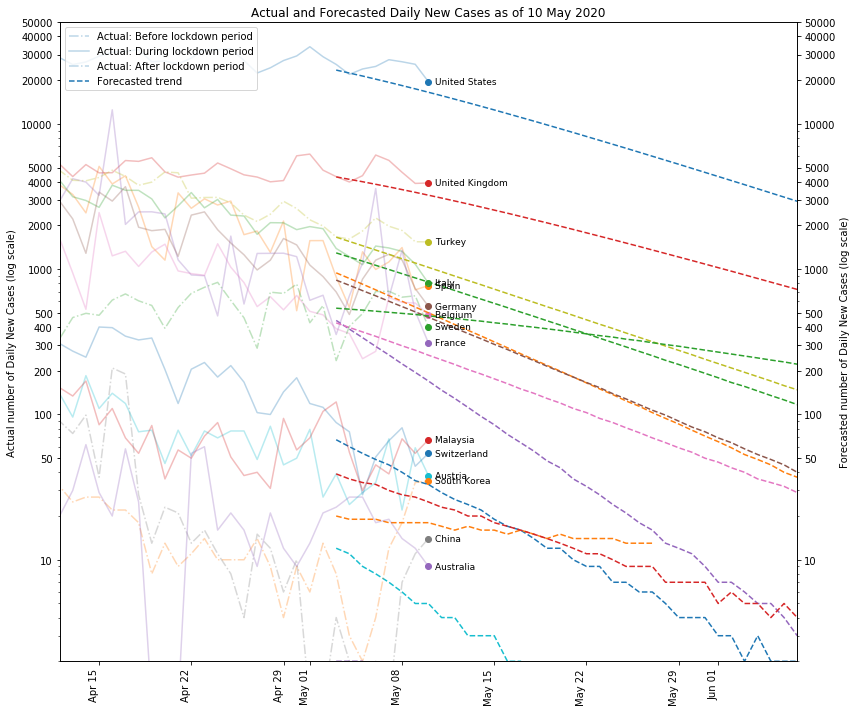

In [58]:
plot_act_fct(countries, ['new_confirmed', 'confirmed', 'new_predict'], yminymax=[2, 5e4], label='Daily New Cases')

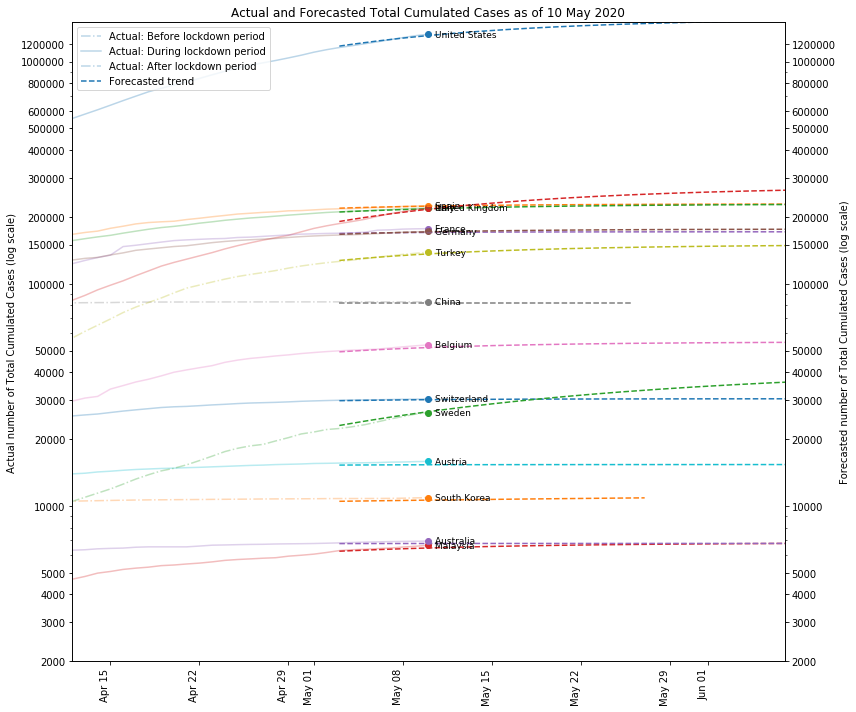

In [59]:
plot_act_fct(countries, ['confirmed', 'confirmed', 'predict'], yminymax=[2e3, 1.5e6], label='Total Cumulated Cases')

In [60]:
def plot_lockdown(country, xmin, txtmin, locklabel=None, showforecast=None):

    # Open source
    data = pd.read_csv(f"data/dfdata/forecast_{country.replace(' ','_')}.csv", index_col=0)
    data.date = pd.to_datetime(data.date)
    
    if xmin!=     None:      xmin = pd.to_datetime(xmin, format='%Y%m%d')
    if txtmin!=   None:    txtmin = pd.to_datetime(txtmin, format='%Y%m%d')

    # Define dates
    latestindex = data[data.confirmed.isnull()].index.min()-1
    latestdate  = data.date.iloc[latestindex]
    if showforecast==None: maxdate = latestdate
    else: maxdate = data.date.max()
    
    if country in list(lockdates.keys()):
        lockstart = pd.to_datetime(lockdates[country]['start'])
        lockstart = latestdate if lockstart > latestdate else lockstart
        lockend   = pd.to_datetime(lockdates[country]['end'])    
        if lockend==None: lockend_now = latestdate
        else: lockend_now = lockend
    else: lockstart, lockend = None, None

    oneday = pd.Timedelta(1, unit='days')
    if xmin==None: xmin=data.date.min()
    if txtmin==None: txtmin=xmin

    fig, ax = plt.subplots(figsize=(12,7))
    mdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

    # Plot Daily cases
    ax.plot(data.date, data.new_confirmed, label='New confirmed cases', alpha=0.8, color='C0')
    ax.plot(data.date, data.new_conf_avg_7, label='New confirmed cases: Past 7 days avg (trend)', alpha=0.8, color='C1')

    # Lockdown start/end
    if lockstart != None:
        ax.vlines(lockstart, -50, data.new_confirmed.max()*1.05, alpha=0.8)
        ax.text(lockstart+oneday/2, data.new_confirmed.max()*0.9,
                f'{locklabel} began {lockstart.day} {mdict[lockstart.month]} {lockstart.year}', rotation=90, va='top')
    if lockend != None:
        ax.vlines(lockend, -50, data.new_confirmed.max()*1.05, alpha=0.8)
        ax.text(lockend-oneday*1.5, data.new_confirmed.max()*0.9,
                f'{locklabel} lifted {lockend.day} {mdict[lockend.month]} {lockend.year}', rotation=90, va='top')
    if lockstart != None:
        # Num of cases at start of lockdown
        data0start = data[data.date==lockstart].new_confirmed.values[0]
        data1start = data[data.date==lockstart].new_conf_avg_7.values[0]
        # Num of cases at end of lockdown (or now, if lockdown is ongoing)
        data0end   = data[data.date==lockend_now].new_confirmed.values[0]
        data1end   = data[data.date==lockend_now].new_conf_avg_7.values[0]
        # Days of lockdown
        lockperiod = (lockend_now - lockstart)

    # Num of cases now
    data0now   = data[data.date==latestdate].new_confirmed.values[0]
    data1now   = data[data.date==latestdate].new_conf_avg_7.values[0]

    # Number of cases
    if lockstart != None:
        # Plot num of cases
        ax.scatter(lockstart, data0start, marker='o', color='C0')
        ax.scatter(lockstart, data1start, marker='o', color='C1')
        ax.scatter(lockend_now, data0end, marker='o', color='C0')
        ax.scatter(lockend_now, data1end, marker='o', color='C1')
        ax.text(lockstart-oneday/2, data0start, f'{int(data0start)} cases', ha='right', color='C0')
        ax.text(lockend_now-oneday/2, data0end, f'{int(data0end)} cases', va='top', ha='right', color='C0')
        if abs(data0start - data1start)/data0start > 0.05:
            ax.text(lockstart-oneday/2, data1start, f'{int(data1start)} cases', ha='right', color='C1')
        if abs(data0end - data1end)/data0end > 0.05:
            ax.text(lockend_now-oneday/2, data1end, f'{int(data1end)} cases', va='top', ha='right', color='C1')
        # Draw lockdown period lines
        if data1start/data.new_confirmed.max() < 0.1: lineheight = data.new_confirmed.max()/2
        else: lineheight = data1start
        ax.hlines(lineheight, lockstart, lockend_now, linestyle='dashed', alpha=0.8, color='C2')
        ax.vlines(lockend_now, lineheight, data1end, linestyle='dashed', alpha=0.8, color='C2')
        if lockend != None: into='of'
        else: into='into'
        ax.text(lockstart+lockperiod/2, lineheight, f'{lockperiod.days+1} days {into} {locklabel}', va='center', ha='center',
                bbox=dict(facecolor='yellow', edgecolor='C2', linewidth=2, linestyle='dashed', alpha=0.8))
    if (lockstart == None) | (lockend != None):
        # Plot latest cases
        ax.scatter(latestdate, data0now, marker='o', color='C0')
        ax.scatter(latestdate, data1now, marker='o', color='C1')
        ax.text(latestdate, data0now, f'{int(data0now)} cases', va='top', ha='right', color='C0')

    # Cumulative cases
    ax2 = ax.twinx()
    ax2.bar(data.date, data.confirmed, label='Cumulative confirmed cases', color='C3', width=0.9, alpha=0.05)
    for i in data[(data.date>=txtmin) & (data.date<=maxdate)].index:
        if data.iloc[i].growth >= 1.1: color='C3'
        elif data.iloc[i].growth >= 1.01: color='C0'
        else: color='C2'
        ax2.text(data.iloc[i].date, data.iloc[i].confirmed, f'+{round((data.growth.iloc[i]-1)*100,1)}%',
                 rotation=90, ha='center', va='top', color=color, fontsize=8)
    # Axis labels 
    ax.set_xlim(xmin, maxdate+oneday)
    ax.set_ylim(0, data.new_confirmed.max()*1.05)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    fig.autofmt_xdate(rotation=90)
    ax.set_ylabel('Num of new confirmed cases')
    ax2.set_ylabel('Num of cumulative confirmed case')
    # plt.annotate('Source: John Hopkins University Hospital based on 00:00 GMT daily reporting cut-off time.\nNew reported cases in the chart are assumed to be in real time based on official figures but a delay of around 48 hours is more likely due to backlogs of RT_PCR.',
    #              (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)

    # Legends
    ax.legend(loc='upper left')
    if data0now/data.new_confirmed.max() < 0.15: legend2loc = 'center right'
    else: legend2loc = 'lower right'
    ax2.legend(loc=legend2loc, title='+%        Day-on-day growth')
    ax.set_title(country, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"img/lockdown_{country.replace(' ','_')}", pad_inches=0)
    plt.show()

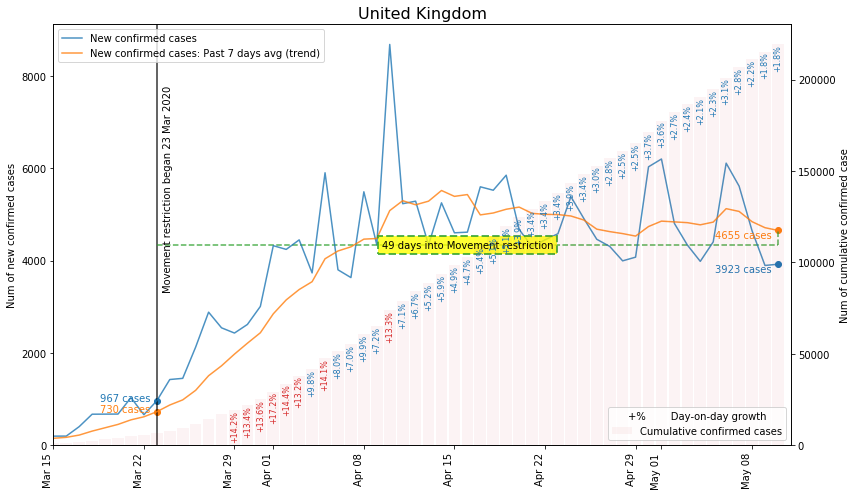

In [61]:
plot_lockdown('United Kingdom', locklabel='Movement restriction', xmin='20200315', txtmin='20200329')

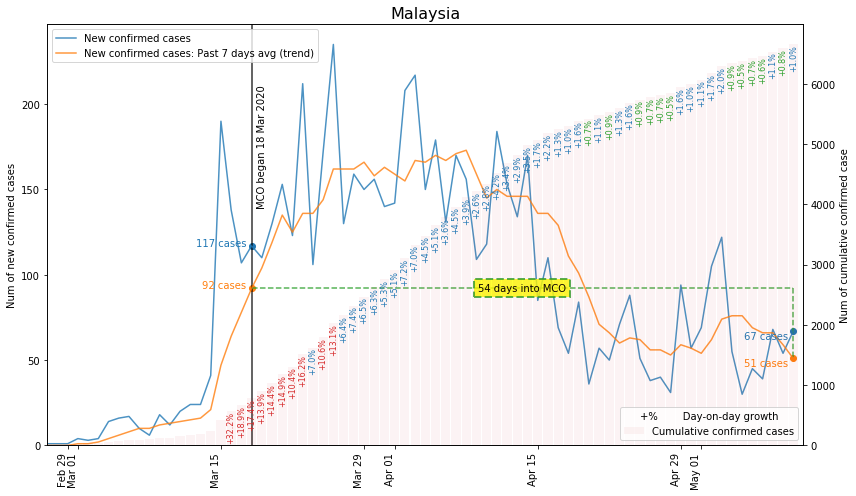

In [62]:
plot_lockdown('Malaysia', locklabel='MCO', xmin='20200227', txtmin='20200316')

In [63]:
# plot_lockdown('Italy', locklabel='Lockdown', xmin='20200222', txtmin='20200309')

In [64]:
# plot_lockdown('France', locklabel='Lockdown', xmin='20200305', txtmin='20200317')

In [65]:
# plot_lockdown('Spain', locklabel='State of Alarm', xmin='20200309', txtmin='20200315')

In [66]:
# plot_lockdown('Germany', locklabel='Movement restriction', xmin='20200309', txtmin='20200315')

In [67]:
# plot_lockdown('Switzerland', locklabel='Lockdown', xmin='20200301', txtmin='20200315')

In [68]:
# plot_lockdown('Austria', locklabel='Lockdown', xmin='20200301', txtmin='20200315')

In [69]:
# plot_lockdown('Singapore', locklabel='Lockdown', xmin='20200308', txtmin='20200308')

In [70]:
# plot_lockdown('China', locklabel='Hubei lockdown', xmin='20200115', txtmin='20200129')

In [71]:
# plot_lockdown('South Korea', xmin='20200216', txtmin='20200225')

In [72]:
def plot_gov_measures(countries, title=None, footnote=None, filename=0):
    # Latest available data
    latestdate = df1.index.max()
    #latestdate = pd.to_datetime("20200408", format='%Y%m%d')
    
#     if len(oxford[oxford.country.isin(countries)].loc[latestdate].country) < len(countries):
#         latestdate = df1.index.max() - oneday # if Oxford data update is behind John Hopkins

    # Formula to shift text labels in case of overlap
    ranking = oxford[oxford.country.isin(countries)].loc[latestdate][['country','stringency']].sort_values(by='stringency').reset_index(drop=True).sort_values('stringency', ascending=False)
    ranking['countrank'] = 1
    for i in range(1,len(ranking)+1):
        temp = ranking.iloc[:i]
        countrank = (temp.stringency==temp.iloc[i-1].stringency).sum()
        ranking.iloc[i-1, -1] = countrank
    shift_y = ranking.set_index('country').countrank

    fig, ax = plt.subplots(figsize=(12,8))
    for c, country in enumerate(ranking.country):
        data = oxford[oxford.country==country].loc[:latestdate]
        color = 'black' if country=='Malaysia' else (f'C{c}' if i < 10 else f'C{str(c)[-1]}')
        if country in list(lockdates.keys()):
            lockstart = pd.to_datetime(lockdates[country]['start'])
            lockstart = latestdate if lockstart > latestdate else lockstart
            lockend   = pd.to_datetime(lockdates[country]['end'])
            plt.plot(data.loc[:lockstart].stringency, color=color, lw=1, label='Outside lockdown period')
            plt.plot(data.loc[lockstart:lockend].stringency, color=color, lw=2.5, label='During lockdown period')
            plt.scatter(lockstart, data.loc[lockstart].stringency, color=color, s=60)
            if lockend != None:
                plt.scatter(lockend, data.loc[lockend].stringency, color=color, s=60)
                plt.text(lockend+oneday, data.loc[lockend].stringency, f'{country} (end)', va='center', color=color)
                plt.plot(data.loc[lockend:].stringency, color=color, lw=1)
            else:
                plt.scatter(latestdate, data.loc[latestdate].stringency, color=color, s=60)
            if c==0: ax.legend(loc='upper left', title='Legend')
        else:
            plt.plot(data.stringency, color=color, lw=1)
        plt.text(data.index[-1]+oneday, data.stringency[-1] - (shift_y[country]-1)*2.5,
                 country, va='center', color=color)

    ax.set_xlim(df1.index.min()-oneday*3, latestdate+oneday*14)
    title = 'Government policies stringency index in fighting Covid-19' if title==None else title
    ax.set_title(title)
    ax.set_ylabel('0 Weakest <--- Govt response stringency index ---> 100 Strongest')        
    plt.annotate(f'Source: Hale, Thomas, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira (2020). Oxford COVID-19 Government Response Tracker\n{footnote}',
                 (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    fig.autofmt_xdate(rotation=90)
    plt.tight_layout()
    plt.savefig(f"img/stringency_msia_timeline_{filename}", pad_inches=0)
    plt.show()

### 5. Benchmarking government response

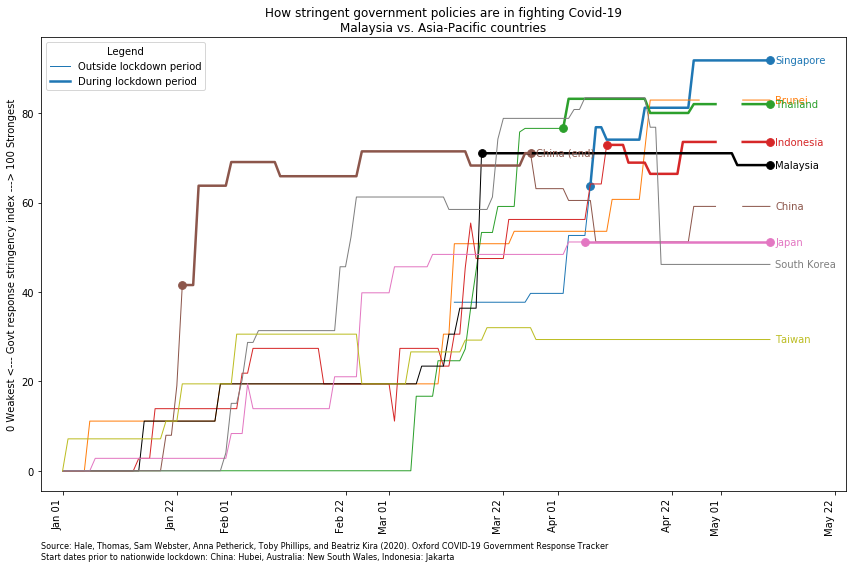

In [73]:
countries = ['Malaysia', 'China', 'South Korea', 'Taiwan', 'Japan',
             'Singapore', 'Thailand', 'Brunei', 'Indonesia']

plot_gov_measures(countries,
                  title='How stringent government policies are in fighting Covid-19\nMalaysia vs. Asia-Pacific countries',
                  footnote='Start dates prior to nationwide lockdown: China: Hubei, Australia: New South Wales, Indonesia: Jakarta',
                  filename='asiapac')

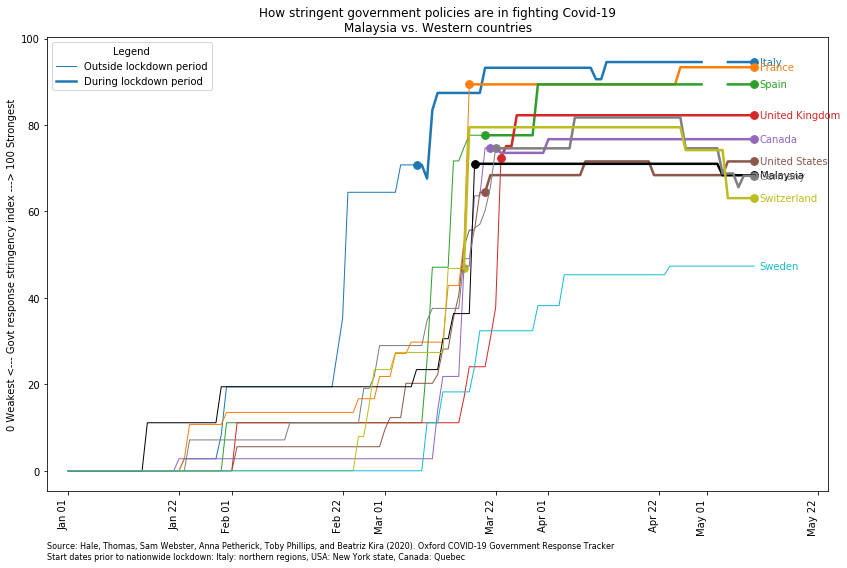

In [74]:
countries = ['Malaysia', 'Spain', 'Italy', 'France', 'Germany', 'Switzerland', 'Sweden',
             'United Kingdom', 'United States', 'Canada']

plot_gov_measures(countries,
                  title='How stringent government policies are in fighting Covid-19\nMalaysia vs. Western countries',
                  footnote='Start dates prior to nationwide lockdown: Italy: northern regions, USA: New York state, Canada: Quebec',
                  filename='west')

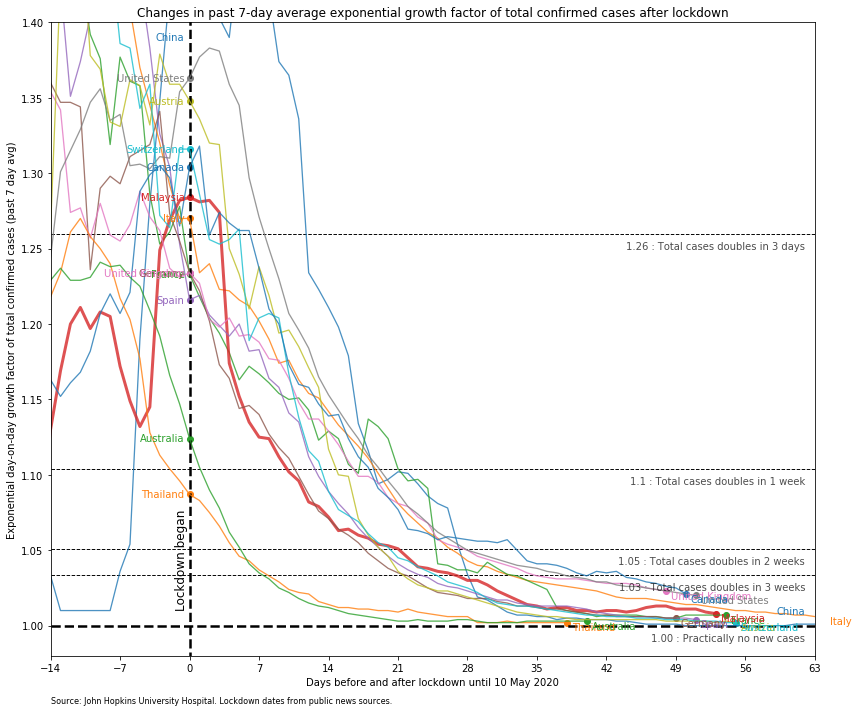

In [75]:
countries = ['China', 'Italy', 'France', 'Malaysia', 'Spain', 'Germany', 'United Kingdom',
             'United States', 'Austria', 'Switzerland', 'Canada', 'Thailand', 'Australia']
fig, ax = plt.subplots(figsize=(12,10))
xmax=7*9
for c, country in enumerate(countries):
    lockstart = pd.to_datetime(lockdates[country]['start'])
    data = df1a[df1a.country==country].reset_index()
    data['dminus'] = data.date.apply(lambda row: (row - lockstart).days)
    dayzero = data[data.date==lockstart].new_confirmed
    data['new_conf_index'] = data.new_confirmed.apply(lambda row: row/dayzero*100).astype(int)
    data = data.set_index('date')
    color = f'C{c}' if c < 10 else f'C{str(c)[-1]}'
    lw = 3 if country=='Malaysia' else 1.3
    measure = 'growth_avg_7'
    plt.plot(data.dminus, data[measure], label=country, color=color, alpha=0.8, lw=lw)
    plt.scatter(0, data[data.dminus==0][measure], color=color)
    plt.scatter(data.dminus.max(), data[measure][0], color=color)
    
    xpos = xmax-1 if country=='China' else data.dminus.max()+0.5
    ypos = data[data.dminus==xmax][measure]+0.005 if country=='China' else data[measure][0]
    xha = 'right' if country=='China' else 'left'
    xva = 'bottom' if country=='China' else 'top'
    plt.text(xpos, ypos, country, color=color, ha=xha, va=xva)    
    ypos0 = 1.39 if country=='China' else data[data.dminus==0][measure]
    plt.text(-0.5, ypos0, country, color=color, va='center', ha='right')

plt.vlines(0,0.95,1.5, linewidth=2.5, linestyle='--')
plt.text(-1.5,1.01,'Lockdown began', rotation=90, va='bottom', fontsize=12)
plt.hlines(2**(1/3),-14,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-1, 2**(1/3)-0.01, f'{round(2**(1/3),2)} : Total cases doubles in 3 days', ha='right', alpha=0.7)
plt.hlines(2**(1/7),-14,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-1, 2**(1/7)-0.01, f'{round(2**(1/7),2)} : Total cases doubles in 1 week', ha='right', alpha=0.7)
plt.hlines(2**(1/14),-14,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-1, 2**(1/14)-0.01, f'{round(2**(1/14),2)} : Total cases doubles in 2 weeks', ha='right', alpha=0.7)
plt.hlines(2**(1/21),-14,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-1, 2**(1/21)-0.01, f'{round(2**(1/21),2)} : Total cases doubles in 3 weeks', ha='right', alpha=0.7)
plt.hlines(1,-14,xmax, linewidth=2.5, linestyle='--')
plt.text(xmax-1, 0.99, '1.00 : Practically no new cases', ha='right', alpha=0.7)

ax.set_ylim(0.98,1.4)
ax.set_xlim(-14,xmax)
ax.set_xticks(range(-14,xmax+1,7))
ax.set_ylabel('Exponential day-on-day growth factor of total confirmed cases (past 7 day avg)')
ax.set_xlabel(f'Days before and after lockdown until {date.day} {mdict[date.month]} 2020')
ax.set_title('Changes in past 7-day average exponential growth factor of total confirmed cases after lockdown')
source='John Hopkins University Hospital.'
footnote='Lockdown dates from public news sources.'
plt.annotate(f'Source: {source} {footnote}',
             (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/lockdown_msia_post_lockdown_1", pad_inches=0)
plt.show()

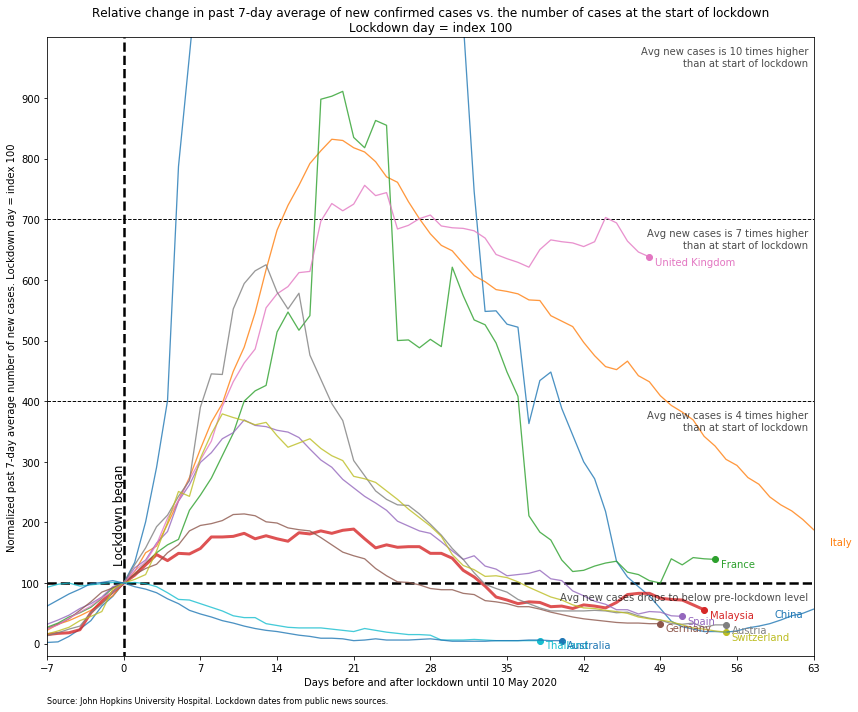

In [76]:
countries = ['China', 'Italy', 'France', 'Malaysia', 'Spain', 'Germany', 'United Kingdom',
             'Austria', 'Switzerland', 'Thailand', 'Australia']
fig, ax = plt.subplots(figsize=(12,10))
xmax=7*9
for c, country in enumerate(countries):
    lockstart = pd.to_datetime(lockdates[country]['start'])
    data = df1a[df1a.country==country].reset_index()
    data['dminus'] = data.date.apply(lambda row: (row - lockstart).days)
    data = data.sort_values('date')
    data['new_conf_avg_7'] = data.new_confirmed.rolling(window=7).mean()
    dayzero = data[data.date==lockstart].new_conf_avg_7
    data['new_conf_index'] = round(data.new_conf_avg_7.apply(lambda row: row/dayzero*100))
    data = data.set_index('date')
    color = f'C{c}' if c < 10 else f'C{str(c)[-1]}'
    lw = 3 if country=='Malaysia' else 1.3
    measure = 'new_conf_index'
    plt.plot(data.dminus, data[measure], label=country, color=color, alpha=0.8, lw=lw)
    plt.scatter(data.dminus.max(), data[measure][-1], color=color)
    xpos = xmax-1 if country=='China' else data.dminus.max()+0.5
    ypos = data[data.dminus==xmax][measure] if country=='China' else data[measure][-1]
    xha = 'right' if country=='China' else 'left'
    plt.text(xpos, ypos, country, color=color, va='top', ha=xha)
plt.vlines(0,-50,1000, linewidth=2.5, linestyle='--')
plt.text(-1,130,'Lockdown began', rotation=90, va='bottom', fontsize=12)
plt.text(xmax-0.5, 985, 'Avg new cases is 10 times higher\nthan at start of lockdown', ha='right', va='top', alpha=0.7)
plt.hlines(700,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 685, 'Avg new cases is 7 times higher\nthan at start of lockdown', ha='right', va='top', alpha=0.7)
plt.hlines(400,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 385, 'Avg new cases is 4 times higher\nthan at start of lockdown', ha='right', va='top', alpha=0.7)
plt.hlines(100,-7,xmax, linewidth=2.5, linestyle='--')
plt.text(xmax-0.5, 85, 'Avg new cases drops to below pre-lockdown level', ha='right', va='top', alpha=0.7)
ax.set_ylim(-20, 1000)
ax.set_xlim(-7,xmax)
ax.set_xticks(range(-7,xmax+1,7))
ax.set_yticks(range(0,1000,100))
ax.set_ylabel('Normalized past 7-day average number of new cases. Lockdown day = index 100')
ax.set_xlabel(f'Days before and after lockdown until {date.day} {mdict[date.month]} 2020')
ax.set_title('Relative change in past 7-day average of new confirmed cases vs. the number of cases at the start of lockdown\nLockdown day = index 100')
source='John Hopkins University Hospital.'
footnote='Lockdown dates from public news sources.'
plt.annotate(f'Source: {source} {footnote}',
             (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/lockdown_msia_post_lockdown_2", pad_inches=0)
plt.show()

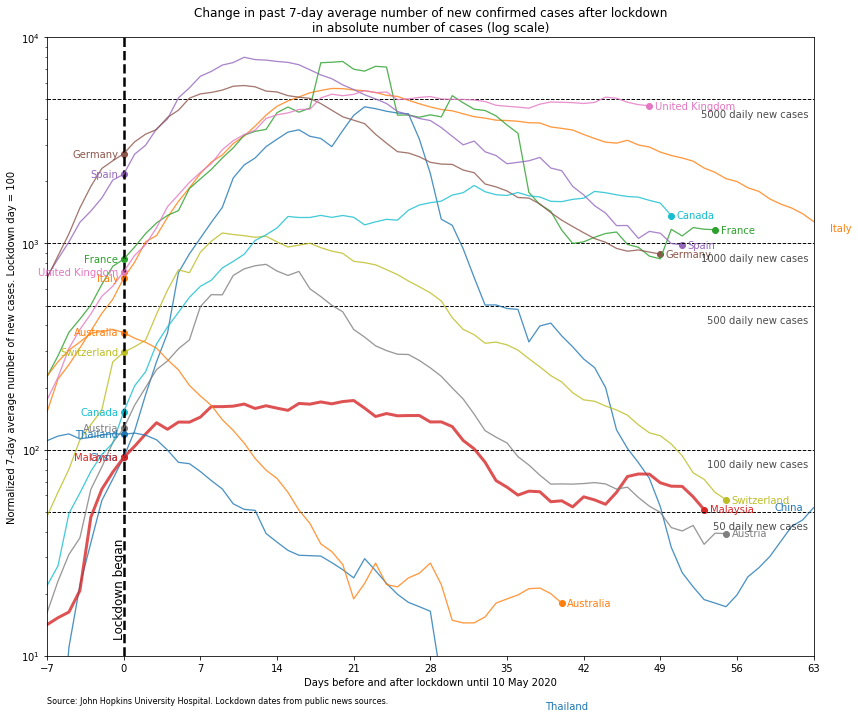

In [77]:
countries = ['China', 'Italy', 'France', 'Malaysia', 'Spain', 'Germany', 'United Kingdom',
             'Austria', 'Switzerland', 'Canada', 'Thailand', 'Australia']
fig, ax = plt.subplots(figsize=(12,10))
xmax=7*9
for c, country in enumerate(countries):
    lockstart = pd.to_datetime(lockdates[country]['start'])
    data = df1a[df1a.country==country].reset_index()
    data['dminus'] = data.date.apply(lambda row: (row - lockstart).days)
    data = data.sort_values('date')
    data['new_conf_avg_7'] = data.new_confirmed.rolling(window=7).mean()
    dayzero = data[data.date==lockstart].new_conf_avg_7
    data['new_conf_index'] = round(data.new_conf_avg_7.apply(lambda row: row/dayzero*100))
    data = data.set_index('date')
    color = f'C{c}' if c < 10 else f'C{str(c)[-1]}'
    lw = 3 if country=='Malaysia' else 1.3
    measure = 'new_conf_avg_7'
    plt.plot(data.dminus, data[measure], label=country, color=color, alpha=0.8, lw=lw)
    plt.scatter(data.dminus.max(), data[measure][-1], color=color)
    plt.scatter(0, data[data.dminus==0][measure], color=color)
    plt.text(-0.5, data[data.dminus==0][measure], country, color=color, va='center', ha='right')
    xpos = xmax-1 if country=='China' else data.dminus.max()+0.5
    ypos = data[data.dminus==xmax][measure] if country=='China' else data[measure][-1]
    xha = 'right' if country=='China' else 'left'
    plt.text(xpos, ypos, country, color=color, va='center', ha=xha)
plt.vlines(0, 10, 5e4, linewidth=2.5, linestyle='--')
plt.text(-1,12,'Lockdown began', rotation=90, va='bottom', fontsize=12)

plt.hlines(0.5e4,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 0.5e4-0.5e3, '5000 daily new cases', ha='right', va='top', alpha=0.7)
plt.hlines(1.0e3,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 1.0e3-1.0e2, '1000 daily new cases', ha='right', va='top', alpha=0.7)
plt.hlines(0.5e3,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 0.5e3-0.5e2, '500 daily new cases', ha='right', va='top', alpha=0.7)
plt.hlines(1.0e2,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 1.0e2-1.0e1, '100 daily new cases', ha='right', va='top', alpha=0.7)
plt.hlines(0.5e2,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 0.5e2-0.5e1, '50 daily new cases', ha='right', va='top', alpha=0.7)

ax.set_ylim(10, 1e4)
ax.set_xlim(-7,xmax)
ax.set_xticks(range(-7,xmax+1,7))
ax.set_ylabel('Normalized 7-day average number of new cases. Lockdown day = 100')
ax.set_xlabel(f'Days before and after lockdown until {date.day} {mdict[date.month]} 2020')
ax.set_title('Change in past 7-day average number of new confirmed cases after lockdown\nin absolute number of cases (log scale)')
plt.yscale('log')
source='John Hopkins University Hospital.'
footnote='Lockdown dates from public news sources.'
plt.annotate(f'Source: {source} {footnote}',
             (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/lockdown_msia_post_lockdown_3", pad_inches=0)
plt.show()

In [78]:
asiapac = ['Malaysia', 'Australia', 'Brunei', 'China', 'Indonesia', 'Japan', 'South Korea',
           'Saudi Arabia', 'United Arab Emirates', 'Jordan', 'Qatar',
           'Hong Kong', 'New Zealand', 'Philippines', 'Singapore','Thailand', 'Vietnam', 'Taiwan']

west = ['Malaysia', 'Austria', 'Belgium', 'Canada', 'Switzerland', 'Germany', 'Denmark', 'Spain', 'Finland', 'France',
        'United Kingdom', 'Ireland', 'Italy', 'Netherlands', 'Norway', 'Portugal', 'Sweden', 'United States']

In [79]:
latestdate = df1.index.max()

cols_std = ['tracing', 'testing','at_home', 'movement', 'immigration', 'school',
            'workplace', 'events', 'gatherings', 'transport']
maxpoints = {'school':3, 'workplace':3, 'events':2, 'transport':2, 'campaigns':2,
             'movement':2, 'immigration':4, 'testing':3, 'tracing':2,
             'gatherings':4, 'at_home':3}

# Set0: nan values remain + add standardized columns
oxford0 = oxford.copy()
for col in cols_std:
    oxford0[f'{col}2'] = oxford0[col].apply(lambda row: row/maxpoints[col])

# Set1: ffill nan values + add standardized columns
oxford1 = oxford.copy()
oxford1.update(oxford1.groupby('country')[cols_std].ffill())
for col in cols_std:
    oxford1[f'{col}2'] = oxford1[col].apply(lambda row: row/maxpoints[col])

# Set2&3: latest dates with ffill
oxford2 = oxford1.loc[latestdate].sort_values(by=['stringency','tracing','testing'], ascending=False)
showcols = [0,20,21,22,23,23,25,26,27,28,29]
oxford3 = oxford2.iloc[:,showcols].set_index('country', drop=True)

xlabels = ['Contact tracing policy', 'Testing policy', 'Stay-at-home order', 'Movement restrictions', 'Immigration controls',
           'School closed', 'Workplace closed', 'Public events cancelled', 'Gathering restrictions', 'Public transport closed']
annot0 = f'Source: Oxford COVID-19 Government Response Tracker.\nScores normalized between 0 (lowest) and 1 (highest).\nUpdated {date.day} {mdict[date.month]} 2020'

# # Original
# oxford2 = oxford1.loc[latestdate].sort_values(by=['stringency','tracing','testing'], ascending=False)
# showcols = [0,20,21,22,23,23,25,26,27,28,29]
# oxford3 = oxford2.iloc[:,showcols].set_index('country', drop=True)

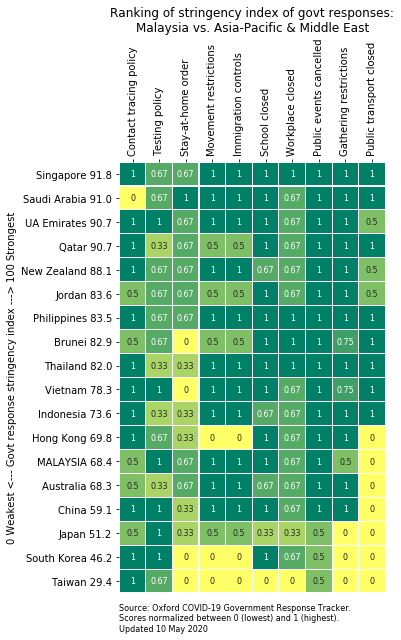

In [80]:
region = asiapac
fig, ax = plt.subplots(figsize=(5.6,9))
temp = oxford2[oxford2.country.isin(region)][['country','stringency']]
temp['ylabel'] = temp.apply(lambda row: f'{row.country} {round(row.stringency,1)}', axis=1)
temp.ylabel = temp.apply(lambda row: row.ylabel.upper() if row.ylabel[:8]=='Malaysia' else row.ylabel, axis=1)
temp.ylabel = temp.apply(lambda row: row.ylabel.replace('United Arab Emirates', 'UA Emirates') if row.ylabel[:20]=='United Arab Emirates' else row.ylabel, axis=1)

sns.heatmap(oxford3.loc[oxford3.index.isin(region)], annot=True, annot_kws={"size": 8}, linewidths=.1,
            xticklabels=xlabels, yticklabels=temp.ylabel.values, cmap='summer_r', cbar=False)

ax.set_title('Ranking of stringency index of govt responses:\nMalaysia vs. Asia-Pacific & Middle East')
ax.set_ylabel('0 Weakest <--- Govt response stringency index ---> 100 Strongest')
ax.xaxis.set_ticks_position('top')
plt.xticks(rotation=90)
plt.annotate(annot0, (0,0), (0, -10), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/stringency_msia_rank_asiapac", pad_inches=0)
plt.show()

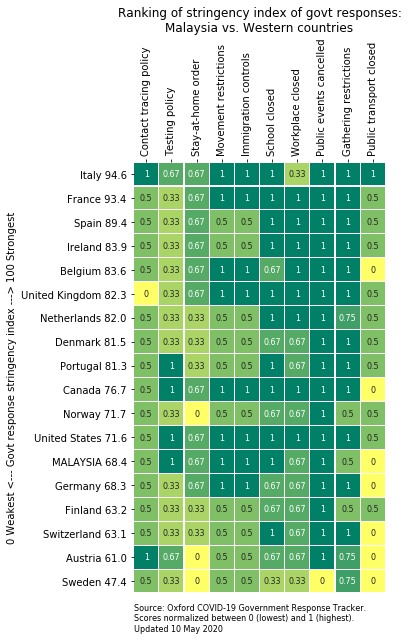

In [81]:
region = west
fig, ax = plt.subplots(figsize=(5.6,9))
temp = oxford2[oxford2.country.isin(region)][['country','stringency']]
temp['ylabel'] = temp.apply(lambda row: f'{row.country} {round(row.stringency,1)}', axis=1)
temp.ylabel = temp.apply(lambda row: row.ylabel.upper() if row.ylabel[:8]=='Malaysia' else row.ylabel, axis=1)

sns.heatmap(oxford3.loc[oxford3.index.isin(region)], annot=True, annot_kws={"size": 8}, linewidths=.1,
            xticklabels=xlabels, yticklabels=temp.ylabel.values, cmap='summer_r', cbar=False)
ax.set_title('Ranking of stringency index of govt responses:\nMalaysia vs. Western countries')
ax.set_ylabel('0 Weakest <--- Govt response stringency index ---> 100 Strongest')
ax.xaxis.set_ticks_position('top')
plt.xticks(rotation=90)
plt.annotate(annot0, (0,0), (0, -10), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/stringency_msia_rank_west", pad_inches=0)
plt.show()

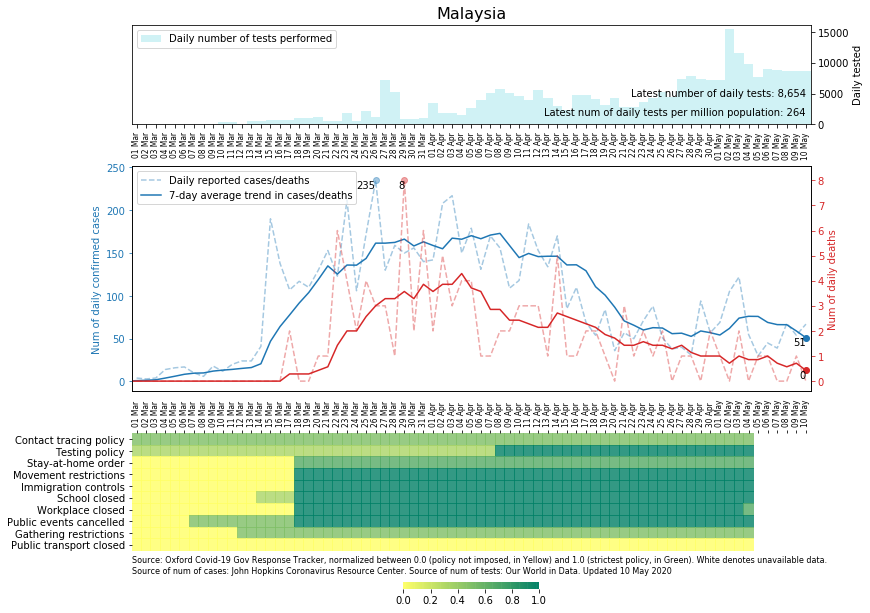

In [110]:
#startdate = '20200302'
#countries = ['Malaysia','Singapore','United Kingdom','United States','Sweden','Italy','France','Spain','Germany','South Korea','Australia','Thailand']
countries = ['Malaysia','Singapore','Thailand','Vietnam','Taiwan','Japan','South Korea','Australia',
             'Spain','Italy','United Kingdom','France','Germany','Sweden',
             'Saudi Arabia','Jordan','Brazil','United States']
#countries = ['Malaysia']

for country in countries:
    enddate = df1.index.max()
    startdate = enddate - oneday*(7*10)
    #startdate = pd.to_datetime(startdate, format='%Y%m%d')
    data0   = df1[df1.country==country].sort_index()[['new_confirmed','new_deaths']].loc[startdate:enddate]
    data0x  = df1[df1.country==country].sort_index()[['new_confirmed','new_deaths']].loc[(startdate-oneday*7):enddate]
    data1   = tests[tests.country==country].loc[startdate:enddate]
    data2   = oxford0[oxford0.country==country].iloc[:,[20,21,22,23,23,25,26,27,28,29]].loc[startdate:enddate]
    ylabels = ['Contact tracing policy', 'Testing policy', 'Stay-at-home order', 'Movement restrictions', 'Immigration controls',
               'School closed', 'Workplace closed', 'Public events cancelled', 'Gathering restrictions', 'Public transport closed']
    strdates = [f'{str(date)[8:10]} {mdict[int(str(date)[5:7])]}' for date in data2.index]

    fig = plt.figure(figsize=(12,8.5))
    gs = gridspec.GridSpec(3, 1, height_ratios=[20,45,35]) 
    ax0, ax1, ax2 = plt.subplot(gs[1]), plt.subplot(gs[0]), plt.subplot(gs[2])

    # Confirmed cases
    ax0.plot(data0.new_confirmed.clip(0), c='C0', alpha=0.4, ls='dashed', label='Daily reported cases/deaths')
    ixmax = data0[data0.new_confirmed==data0.new_confirmed.max()].index[0]
    ax0.scatter(ixmax, data0.new_confirmed.max(), c='C0', alpha=0.4)
    ax0.text(ixmax, data0.new_confirmed.max(), format(int(data0.new_confirmed.max()),","), va='top', ha='right')

    # Confirmed cases 7 day avg
    ax0.plot(data0x.new_confirmed.rolling(7).mean().clip(0), c='C0', label='7-day average trend in cases/deaths')
    ax0.scatter(data0.index[-1], data0.new_confirmed.rolling(7).mean()[-1], c='C0')
    ax0.text(data0.index[-1], data0.new_confirmed.rolling(7).mean()[-1], format(int(round(data0.new_confirmed.rolling(7).mean()[-1])),","), va='top', ha='right')

    ax02 = ax0.twinx()
    # Deaths
    if data0.new_deaths.max()>0:
        ax02.plot(data0.new_deaths.clip(0), c='C3', alpha=0.4, ls='dashed')
        ixmax = data0[data0.new_deaths==data0.new_deaths.max()].index[0]
        ax02.scatter(ixmax, data0.new_deaths.max(), c='C3', alpha=0.4)
        ax02.text(ixmax, data0.new_deaths.max(), format(int(data0.new_deaths.max()),","), va='top', ha='right')

    # Deaths 7 day avg
    if data0.new_deaths.max()>0:
        ax02.plot(data0x.new_deaths.rolling(7).mean().clip(0), c='C3')
        ax02.scatter(data0.index[-1], data0.new_deaths.rolling(7).mean()[-1], c='C3')
        ax02.text(data0.index[-1], data0.new_deaths.rolling(7).mean()[-1], format(int(round(data0.new_deaths.rolling(7).mean()[-1])),","), va='top', ha='right')
    
    ax0.set_xticks([])
    ax0.set_xlim(data0.index.min()-oneday*0.5, data0.index.max()+oneday*0.5)
    
    ax0.set_ylabel('Num of daily confirmed cases')
    ax0.yaxis.label.set_color('C0')
    ax0.tick_params(axis='y', colors='C0')
    ax02.set_ylabel('Num of daily deaths')
    ax02.yaxis.label.set_color('C3')
    ax02.tick_params(axis='y', colors='C3')
    
    ax0.legend(loc='upper left')

    # Tests
    if len(data1.country)>0:
        ax1.bar(data1.index, data1.tested_daily.clip(0), color='C9', alpha=0.2, ls='dashed', label='Daily number of tests performed', width=1)
        # for n in range(len(data1)):
        #     label = int(data1.testper1Mdaily.iloc[n]) if data1.testper1Mdaily.iloc[n]/data1.testper1Mdaily.max()>0.1 else ''
        #     ax1.text(data1.index[n], data1.tested_daily.iloc[n], label, rotation=90, ha='center', va='top', fontsize=8)
        ax1.text(data1.index[-1], data1.tested_daily.max()*0.3, f'Latest number of daily tests: {format(int(data1.tested_daily_ffill[-1]),",")}', ha='right')
        ax1.text(data1.index[-1], data1.tested_daily.max()*0.1, f'Latest num of daily tests per million population: {format(int(data1.testper1Mdaily_ff[-1]),",")}', ha='right')

        ax1.set_xticks(data0.index)
        ax1.set_xticklabels(strdates)
        ax1.tick_params(axis='x', labelrotation=90, labelsize=7.5)
        ax1.set_xlim(data1.index.min()-oneday*0.5, data1.index.max()+oneday*0.5)
        ax1.set_ylabel('Daily tested')
        
        ax1.yaxis.set_label_position("right")
        ax1.yaxis.tick_right()
        ax1.tick_params(labelright=True, right=True, which='both')
        ax1.legend(loc='upper left')
    else:
        ax1.text(len(strdates)/2,0.5,f'Testing data not available for {country}', ha='center')
        ax1.set_xticks(range(len(strdates)))
        ax1.set_xticklabels(strdates)
        ax1.tick_params(axis='x', labelrotation=90, labelsize=7.5)
        ax1.set_yticks([])

    ax1.set_title(country, fontsize=16)

    # Oxford data
    timeline = sns.heatmap(data2.T.values, cmap='summer_r', alpha=0.8, yticklabels=ylabels, xticklabels=strdates, ax=ax2,
                          cbar_kws={'orientation': 'horizontal', 'shrink':0.2, 'pad':0.18})
    timeline.set_xticklabels(timeline.get_xticklabels(), rotation=90, fontsize=7.5)
    ax2.xaxis.set_ticks_position('top')
    annot = f'Source: Oxford Covid-19 Gov Response Tracker, normalized between 0.0 (policy not imposed, in Yellow) and 1.0 (strictest policy, in Green). White denotes unavailable data.\nSource of num of cases: John Hopkins Coronavirus Resource Center. Source of num of tests: Our World in Data. Updated {date.day} {mdict[date.month]} 2020'
    ax2.annotate(annot, (0,0), (0, -5), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)

    plt.xticks(rotation=90)
    plt.tight_layout(pad=0.4)
    plt.savefig(f"img/gov_policy_vs_cases_{country.replace(' ','_')}", pad_inches=0)
    plt.show()

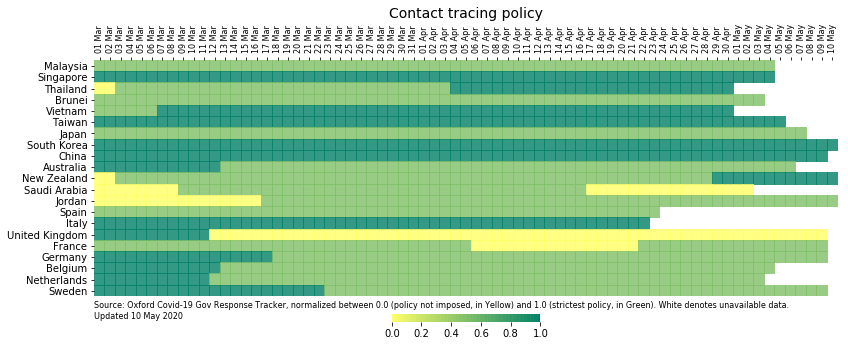

In [111]:
countries = ['Malaysia','Singapore','Thailand','Brunei','Vietnam','Taiwan','Japan','South Korea','China','Australia','New Zealand','Saudi Arabia','Jordan',
             'Spain','Italy','United Kingdom','France','Germany','Belgium','Netherlands', 'Sweden']
colkeys = {'tracing2':'Contact tracing policy', 'testing2':'Testing policy', 'at_home2':'Stay-at-home order',
           'movement2':'Movement restrictions', 'immigration2':'Immigration controls', 'school2':'School closed',
           'workplace2':'Workplace closed', 'events2':'Public events cancelled', 'gatherings2':'Public gathering restrictions',
           'transport2':'Public transport closed'}
colkeys = {'tracing2':'Contact tracing policy'}

for col in colkeys.keys():
    data4 = oxford0[oxford0.country.isin(countries)][['country',col]].fillna(-1)
    data4 = pd.pivot_table(data4.reset_index(), values=[col], index=['date'], columns=['country'], aggfunc='sum').loc[startdate:enddate]
    data4.columns = data4.columns.droplevel()
    data4 = data4[countries]
    data4 = data4.replace(-1,np.nan)

    fig, ax = plt.subplots(figsize=(12,5))
    timeline = sns.heatmap(data4.T.values, cmap='summer_r', alpha=0.8, yticklabels=countries, xticklabels=strdates, ax=ax,
                           cbar_kws={'orientation': 'horizontal', 'shrink':0.2, 'pad':0.06})
    timeline.set_xticklabels(timeline.get_xticklabels(), rotation=90, fontsize=8)
    ax.xaxis.set_ticks_position('top')
    ax.set_title(colkeys[col], fontsize=14)
    annot = f'Source: Oxford Covid-19 Gov Response Tracker, normalized between 0.0 (policy not imposed, in Yellow) and 1.0 (strictest policy, in Green). White denotes unavailable data.\nUpdated {date.day} {mdict[date.month]} 2020'
    ax.annotate(annot, (0,0), (0, -5), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
        
    plt.tight_layout(pad=0.4)
    plt.savefig(f"img/gov_policy_benchmark_{col[:-1]}", pad_inches=0)
    plt.show()

### 6. Are countries testing enough?

In [103]:
latestdate0 = df1.index.max()
df5 = testnum.loc[latestdate0]
df5 = df5.join(ccodes, on='country')
df5 = df5.join(df1.loc[latestdate0][['country','confirmed','deaths']].set_index('country'), on='country').set_index('country')
df5 = df5.join(pop)

In [104]:
df5['test_per_pop'] = df5['tested']/df5['pop']*1000
df5['conf_per_pop'] = df5['confirmed']/df5['pop']*1000
df5['death_per_pop'] = df5['deaths']/df5['pop']*1000
df5['conf_per_test'] = df5['confirmed']/df5['tested']
df5['death_per_test'] = df5['deaths']/df5['tested']

from sklearn.linear_model import LinearRegression
def reg_line (m, c, xs):
    return [(m*x)+c for x in xs]

In [105]:
mindeath, maxdeath = 1, 1e4
mintest, maxtest = 2e3, 2e6
minfit, maxfit = 1, 1e4
fitdata = df5[(df5.deaths>minfit) & (df5.deaths<maxfit)]
linreg = LinearRegression(fit_intercept=True)
linreg.fit(np.array(fitdata.deaths).reshape(-1, 1), np.array(fitdata.tested).reshape(-1, 1))
c = linreg.intercept_[0]
m = linreg.coef_[0][0]

data = df5[(df5.deaths>mindeath) & (df5.deaths<maxdeath) & (df5.tested>mintest)]
fig, ax = plt.subplots(figsize=(12,9))
plt.scatter(data.deaths, data.tested, alpha=0.2, s=data.death_per_pop*1e5, c='C0')
plt.scatter(data.deaths, data.tested, s=20, c='C0')
for i in range(len(data)):
    plt.text(data.deaths.iloc[i]*0.9, data.tested.iloc[i], data.index[i],
             va='center', ha='right', fontsize=8, alpha=0.8)
plt.scatter(data.deaths.loc['Malaysia'], data.tested.loc['Malaysia'], s=20, alpha=0.7, c='black')

xplot = np.linspace(minfit,maxfit,maxfit)
plt.plot(xplot, reg_line(m, c, xplot), alpha=0.5, linestyle='dashed', linewidth=4)
plt.fill_between(xplot, reg_line(m, c, xplot), alpha=0.1, color='C0')
plt.text(1e2, 0.7e4, 'Shaded areas:\nNumber of tests performed are more likely to be insufficient', ha='center', color='C0', fontsize=12)

#plt.vlines(data.deaths.loc['Malaysia'], mintest, maxtest, linestyle='dashed', alpha=0.5)
#plt.hlines(data.tested.loc['Malaysia'], mindeath, maxdeath, linestyle='dashed', alpha=0.5)
plt.ylabel('Number of tests performed (log)')
plt.xlabel('Number of deaths (log)')
ax.set_title('Number of deaths vs. number of tests performed\nCircle size = Number of deaths per population')
plt.xscale('log')
plt.yscale('log')
ax.set_xlim(mindeath, maxdeath)
ax.set_ylim(mintest, maxtest)
plt.annotate(f'Source for num of deaths: John Hopkins University. Source for num of tests: Our World in Data. Updated as of {latestdate}\nNote that official tally of number of tests performed is not widely available for all countries.', (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/test_vs_deaths", pad_inches=0)
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
mindeath, maxdeath = 1, 1e4
minconfirmed, maxconfirmed = 100, 1e5
fitdata = df1[(df1.deaths>mindeath) & (df1.deaths<maxdeath)].loc[latestdate0].join(ccodes, on='country')
linreg = LinearRegression(fit_intercept=True)
linreg.fit(np.array(fitdata.deaths).reshape(-1, 1), np.array(fitdata.confirmed).reshape(-1, 1))
c = linreg.intercept_[0]
m = linreg.coef_[0][0]

data = df1[(df1.deaths>mindeath) & (df1.confirmed>minconfirmed) &
           (df1.confirmed<maxconfirmed)].loc[latestdate0].join(ccodes, on='country')
fig, ax = plt.subplots(figsize=(12,11))
plt.scatter(data.deaths, data.confirmed, s=100, alpha=0.5, c='C1')
for i in range(len(data)):
    plt.text(data.deaths.iloc[i]*0.9, data.confirmed.iloc[i], data.country.iloc[i],
             va='center', ha='right', fontsize=8, alpha=0.8)
msia = data.country=='Malaysia'
plt.scatter(data.deaths[msia], data.confirmed[msia], s=100, alpha=0.5, c='black')

xplot = np.linspace(mindeath,maxdeath,maxdeath)
plt.plot(xplot, reg_line(m, c, xplot), c='C1', alpha=0.5, linestyle='dashed', linewidth=4)
plt.fill_between(xplot, reg_line(m, c, xplot), alpha=0.05, color='C1')
plt.text(1e3, 1e3, 'Shaded areas:\nTotal confirmed cases are\nmore likely to be under-reported', ha='center', color='C1', fontsize=12)
plt.text(1e1, 2e4, 'Total confirmed cases are more likely\nto be correctly reported', ha='center', color='black', fontsize=12, alpha=0.5)

#plt.vlines(data.deaths[msia], 0, maxconfirmed, linestyle='dashed', alpha=0.5)
#plt.hlines(data.confirmed[msia], 0, maxdeath, linestyle='dashed', alpha=0.5)
plt.xlabel('Number of deaths (log)')
plt.ylabel('Number of confirmed cases (log)')
ax.set_title('Num of deaths vs. num of confirmed cases')
plt.xlim(mindeath, maxdeath)
plt.ylim(minconfirmed, maxconfirmed)
plt.xscale('log')
plt.yscale('log')
plt.annotate(f'Data source: John Hopkins University as of {latestdate}\nLikelihood of under-reporting of cases is based on the assumption that the number of deaths is a more accurate representation of Covid-19 spread\ndue to different testing policies per country.', (0,0), (0, -30), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/death_vs_confirmed", pad_inches=0)
plt.show()


In [ ]:
minconfirmed, maxconfirmed   = 10, 1.2e7
minconfirmed2, maxconfirmed2 = 10, 1.2e7
data0 = df1[df1.deaths>0].loc[latestdate0].join(ccodes, on='country')
#drate = data0.deaths.sum()/data0.confirmed.sum() # Using John Hopkins
drate = 0.0072 # assume 1%
data = df1[(df1.deaths>0) & (df1.confirmed>minconfirmed) & (df1.confirmed<maxconfirmed2)].loc[latestdate0].join(ccodes, on='country')[['country','confirmed','deaths','ccode2']]
data['confirmed2'] = data.deaths/drate

fig, ax = plt.subplots(figsize=(12,11))
plt.scatter(data.confirmed, data.confirmed2, s=100, alpha=0.5, c='C2')
for i in range(len(data)):
    plt.text(data.iloc[i].confirmed*0.9, data.iloc[i].confirmed2, data.iloc[i].ccode2,
             va='center', ha='right', fontsize=8, alpha=0.8)
    
xplot = np.linspace(0,1e7,1e3)
plt.plot(xplot, xplot, c='C2')

# msia = data.country=='Malaysia'
# plt.scatter(data.confirmed2[msia], data.confirmed[msia], s=100, alpha=0.7, c='C1')
# plt.hlines(data.confirmed[msia], 0, maxconfirmed2, linestyle='dashed', alpha=0.5)
# plt.vlines(data.confirmed2[msia], 0, maxconfirmed, linestyle='dashed', alpha=0.5)

plt.ylabel(f'Derived num of positive cases = num of deaths divided by CFR death rate of {drate*100}% (log)')
plt.xlabel('Number of officially reported confirmed cases (log)')
ax.set_title(f'Number of officially reported cases vs. theoretical positive cases using {drate*100}% CFR')
ax.set_ylim(minconfirmed, maxconfirmed)
ax.set_xlim(minconfirmed2, maxconfirmed2)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(14,12))
# countries = ['United States', 'Italy', 'Germany', 'Ireland', 'Spain', 'United Kingdom', 'France',
#              'Sweden', 'Turkey', 'Switzerland', 'Australia', 'Belgium', 'Canada',
#              'South Korea', 'Singapore', 'Malaysia', 'Japan', 'New Zealand', 'Taiwan']
# for c, country in enumerate(countries):
#     plt.plot(tests[tests.country==country].testper1Mdaily[30:].rolling(7).mean(), label=country, alpha=0.7)
#     latestdata = tests[tests.country==country].tested_daily[-1]
#     ctext = f'{country} {format(int(latestdata),",")} daily tests'
#     plt.text(tests[tests.country==country].index[-1], tests[tests.country==country].testper1Mdaily[30:].rolling(7).mean()[-1],
#              country, va='center', fontsize=8)
# #plt.yscale('log')
# plt.annotate(f'Numbers indicate the latest daily number of tests by country.', (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
# ax.set_xlim(tests[tests.country==country].index[-60], tests[tests.country==country].index[-1]+oneday*5)
# ax.set_ylim(-50,1600)
# ax.set_title('Total number of daily tests per million population (past 7 days average)')
# ax.set_ylabel('Tests per million population')
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
# fig.autofmt_xdate(rotation=90)
# plt.show()

In [ ]:
# countries = list(latest[:17].country) + ['Ireland','Australia', 'Malaysia']
# fig, axes = plt.subplots(ncols=5, nrows=round(len(countries)/5), figsize=(12,9), constrained_layout=True)
# for c, ax in zip(range(len(countries)), axes.flat):
#     data = df1[(df1.country==countries[c])&(df1.confirmed>=100)].sort_index()[-7*6:]
# #     if data.country[0]=='China':
# #         data.loc[pd.to_datetime("20200417", format='%Y%m%d'),'new_deaths'] = 0
#     scaler = MinMaxScaler()
#     drate = round(data.iloc[-1].deaths/data.iloc[-1].confirmed*100,1)
#     data_scaled1  = scaler.fit_transform(np.array(data.new_confirmed.rolling(7).mean()).reshape(-1, 1))
#     data_scaled2  = scaler.fit_transform(np.array(data.new_deaths.rolling(7).mean()).reshape(-1, 1))
#     data_scaled1a = scaler.fit_transform(np.array(data.new_confirmed).reshape(-1, 1))
#     data_scaled2a = scaler.fit_transform(np.array(data.new_deaths).reshape(-1, 1))
#     ax.plot(data_scaled1, label='Cases', c='C2')
#     ax.plot(data_scaled2, label='Deaths',c='C3')
#     ax.plot(data_scaled1a, label='Cases', c='C2', alpha=0.15)
#     ax.plot(data_scaled2a, label='Cases', c='C3', alpha=0.15)
    
#     #ax.scatter(len(data_scaled1),data_scaled1[-1], c='C2')
#     #ax.text(len(data_scaled1)+2,data_scaled1[-1], format(int(data.new_confirmed.rolling(7).mean()[-1]), ","), color='C2')
#     #ax.text(len(data_scaled2)+2,data_scaled2[-1], format(int(data.new_deaths.rolling(7).mean()[-1]), ","), color='C3')
#     ax.set_title(f'{countries[c]} {drate}%', fontsize=12)
#     ax.axis('off')
#     #ax.legend(loc='upper left')
# plt.tight_layout()

In [ ]:
# drate = df1.loc[latestdate][['country','confirmed','deaths']]
# drate['d_rate'] = round(drate.deaths/drate.confirmed*100,2)
# drate = drate.sort_values('d_rate', ascending=False)
# drate[drate.deaths>=100][:20]

### US Analysis

In [ ]:
us2016 = pd.read_html('https://en.wikipedia.org/wiki/2016_United_States_elections', header=1)[1].set_index('Subdivision').iloc[:,5:6]
us2016.rename(columns={us2016.columns[0]:'pres'}, inplace=True)

usgov = pd.read_html('https://en.wikipedia.org/wiki/List_of_United_States_governors', header=1)[0].set_index('State').iloc[:,3:4]
usgov.rename(columns={usgov.columns[0]:'gov'}, inplace=True)
usgov = pd.DataFrame(usgov.apply(lambda row: row.gov[:3], axis=1), columns=['gov'])

usa = df[df.country=='United States']
usa = usa.join(us2016, on='state')
usa.pres = usa.apply(lambda row: 'NY' if row.state=='New York' else ('Rep' if row.pres=='Rep' else 'Dem'), axis=1)
usa = usa.join(usgov, on='state')
usa.gov = usa.apply(lambda row: 'NY' if row.state=='New York' else ('Rep' if row.gov=='Rep' else 'Dem'), axis=1)

In [ ]:
# usa2 = pd.DataFrame(usa.groupby(['gov','date']).agg('sum')).reset_index().set_index('date')
# fig, ax = plt.subplots(figsize=(12,5), nrows=1, ncols=2)
# for i, t in enumerate(['NY','Dem','Rep']):
#     usdata = usa2[usa2.gov==t]
#     labels = ['New York State: Democrat governor','Other States with Democrat governor','States with Republican governor']
#     colors = ['C0','blue','C3']
#     ax[0].plot(usdata.new_confirmed.rolling(7).mean().iloc[-45:], label=labels[i], color=colors[i])
#     ax[1].plot(usdata.new_deaths.rolling(7).mean().iloc[-45:], label=labels[i], color=colors[i])
#     ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
#     ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
#     fig.autofmt_xdate(rotation=90)
#     ax[0].legend()
#     ax[1].legend()
#     ax[0].set_title('Num of new Confirmed Cases: 7-day average')
#     ax[1].set_title('Num of new Confirmed Deaths: 7-day average')
# plt.tight_layout()

In [ ]:
# usa2 = pd.DataFrame(usa.groupby(['gov','date','state']).agg('sum')).reset_index().set_index('date')
# fig, ax = plt.subplots(figsize=(12,10), nrows=1, ncols=2)
# states = list(usa2.state.unique())
# remove = {'Cruise United States','Unassigned','Wuhan Evacuee','Recovered'} 
# states = [ele for ele in states if ele not in remove] 
# for s in states:
#     usdata = usa2[usa2.state==s]
#     gov = usa2[usa2.state==s].loc[latestdate].gov
#     color = 'C3' if gov=='Rep' else 'C0'
#     ax[0].plot(usdata.new_confirmed.rolling(7).mean().clip(1).iloc[-45:], color=color, alpha=0.6)
#     ax[1].plot(usdata.new_deaths.rolling(7).mean().clip(1).iloc[-45:], color=color, alpha=0.6)
#     ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
#     ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
#     fig.autofmt_xdate(rotation=90)
#     #ax[0].legend()
#     #ax[1].legend()
#     ax[0].set_yscale('log')
#     ax[1].set_yscale('log')
#     ax[0].set_title('Num of new Confirmed Cases: 7-day average')
#     ax[1].set_title('Num of new Confirmed Deaths: 7-day average')
# plt.tight_layout()

In [ ]:
usa2 = pd.DataFrame(usa.groupby(['gov','date','state']).agg('sum')).reset_index().set_index('date')
fig, ax = plt.subplots(figsize=(12,12))
states = list(usa2.state.unique())
remove = {'Cruise United States','Unassigned','Wuhan Evacuee','Recovered'} 
states = [ele for ele in states if ele not in remove] 
for s in states:
    usdata = usa2[usa2.state==s]
    gov = usa2[usa2.state==s].loc[latestdate].gov
    color = 'C3' if gov=='Rep' else 'C0'
    total_deaths = usdata.deaths
    new_deaths = usdata.new_deaths.rolling(7).mean().clip(1)
    ax.plot(total_deaths.iloc[-45:], new_deaths.iloc[-45:], color=color, alpha=0.6)
    ax.text(total_deaths[-1], new_deaths[-1], s, alpha=0.7, fontsize=9)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    fig.autofmt_xdate(rotation=90)
    #ax[0].legend()
    #ax[1].legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1,8e4)
    ax.set_ylim(1,2e3)
    ax.set_title('Num of New cases vs. Num of Total cases')
plt.tight_layout()

In [ ]:
# lock = pd.read_html('https://en.wikipedia.org/wiki/National_responses_to_the_2019%E2%80%9320_coronavirus_pandemic', header=0)[2][:-1]
# lock.columns = lock.iloc[0]
# lock.drop(0, inplace=True)
# lock = lock.rename(columns={lock.columns[0]: 'country', lock.columns[1]: 'area', lock.columns[2]: 'start', lock.columns[3]: 'end', lock.columns[4]: 'level'})
# lock.start = pd.to_datetime(lock.start.apply(lambda row: str(row)[:10]), format='%d-%m-%Y')
# lock.end   = pd.to_datetime(lock.end.apply(lambda row: str(row)[:10]), format='%d-%m-%Y')
# lock.level = lock.level.apply(lambda row: row if row.find('[')==-1 else str(row)[:row.find('[')])
# lock = lock.set_index('country')